In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import pathlib
import seaborn as sns
import re

from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")


In [2]:
%matplotlib inline

# MPI Benchmark

This notebook contains graphics of the `all-dist` test suite run with 32 processors on a `scatterv` binary built with the OpenMPI 4.1.6 and MPICH 4.1.2 implementation on [Hydra](https://doku.par.tuwien.ac.at/docs/machines/hydra/). The goal of this test suite is to compare the performance of the two MPI implementations to each other. The code is essentially equal to the code found in `plot.py` with small modifcations to put the results of both MPI implementations side-by-side.


The `main` function processes a CSV file containing MPI benchmark data to visualize latency performance across different ranks and iterations. It begins by reading the CSV file and defining column types for efficient data handling. Then, it calculates the latency for each entry by subtracting the Starttime from the Endtime and converting the result to microseconds. The function filters the data to focus on the 95th percentile of latency values, ensuring that only the most relevant data is used. It then computes a rolling average of the latency over a window of 1000 data points for smoother analysis.

The function generates two plots: a violin plot that shows the distribution of latency values for each rank, and a line plot that illustrates the average latency per iteration, with error bars representing the standard deviation. These plots help visualize the latency behavior across ranks and over iterations, providing insights into the performance of different processes in the MPI benchmarking. The plots are drawn on specified axes (ax) and include appropriate labels, titles, and legends for clarity. The MPI type ("OpenMPI" or "MPICH") is determined from the filename and incorporated into the plot titles.




In [3]:
def plot(test: str):
    base = pathlib.Path()
    files = [f for f in list(base.glob(f"**/*{test}.csv")) if not f.name.split("-")[0].isdigit()]
    n = len(files)
    
    fig = plt.figure(layout="constrained", figsize=(28, 7*n))
    gs = GridSpec(2*n, 2, figure=fig)

    ax = list()
    for i in range(n):
        ax1 = fig.add_subplot(gs[i * 2, :])
        ax2 = fig.add_subplot(gs[(i * 2) + 1, 0])
        ax3 = fig.add_subplot(gs[(i * 2) + 1, 1])
        ax.append([ax1, ax2, ax3])

    q = 0.95
    head = {"Rank": np.int16,
            "Iteration": np.int32,
            "Starttime": np.float64,
            "Endtime": np.float64}
    
    for filename, (ax1, ax2, ax3) in zip(files, ax):
        mpi = "OpenMPI" if "openmpi" in str(filename) else "MPICH"
        df = pd.read_csv(filename, dtype=head)
        df["Latency"] = (df["Endtime"] - df["Starttime"]) * 1e6
        
        q95 = df[(df["Latency"] <= df["Latency"].quantile(q)) & (df["Latency"] >= df["Latency"].quantile(float(format(1-q, ".2f"))))].copy()
        q95["Avg Latency"] = q95["Latency"].rolling(window=1000).mean()
    
        sns.violinplot(
            data=q95,
            x="Rank",
            y="Latency",
            ax=ax1
        )
        ax1.set_title(f"Violin plot: {mpi}")
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles, labels, loc="upper left", fontsize="small")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Latency")
        
        sns.lineplot(
            data=q95,
            x="Iteration",
            y="Avg Latency",
            hue="Rank",
            lw=1,
            err_style="band",
            errorbar="sd",
            ax=ax2
        )
        ax2.set_title(f"Average Latency per iteration per rank: {mpi}")
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles, labels, loc="upper left", fontsize="small")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Latency")
    
        q95m = q95.groupby(["Iteration"]).max()
            
        sns.lineplot(
            data=q95m,
            x="Iteration",
            y="Avg Latency",
            #hue="Rank",
            lw=1,
            err_style="band",
            errorbar="sd",
            ax=ax3
        )
        ax3.set_title(f"Average Max Latency per iteration over all ranks: {mpi}")
    
    fig.suptitle(f"Benchmark: {test}", fontsize=16)    
    fig.savefig(f"{test}-figure.png", dpi=300)

# Equal

``` json
    {
        "test_name": "scatterv-equal",
        "test_type": "latency",
        "collective": "scatterv",
        "messages_data": {
            "data": "equal",
            "params": {
                "nproc": 32,
                "val": 10
            }
        }
    }
```

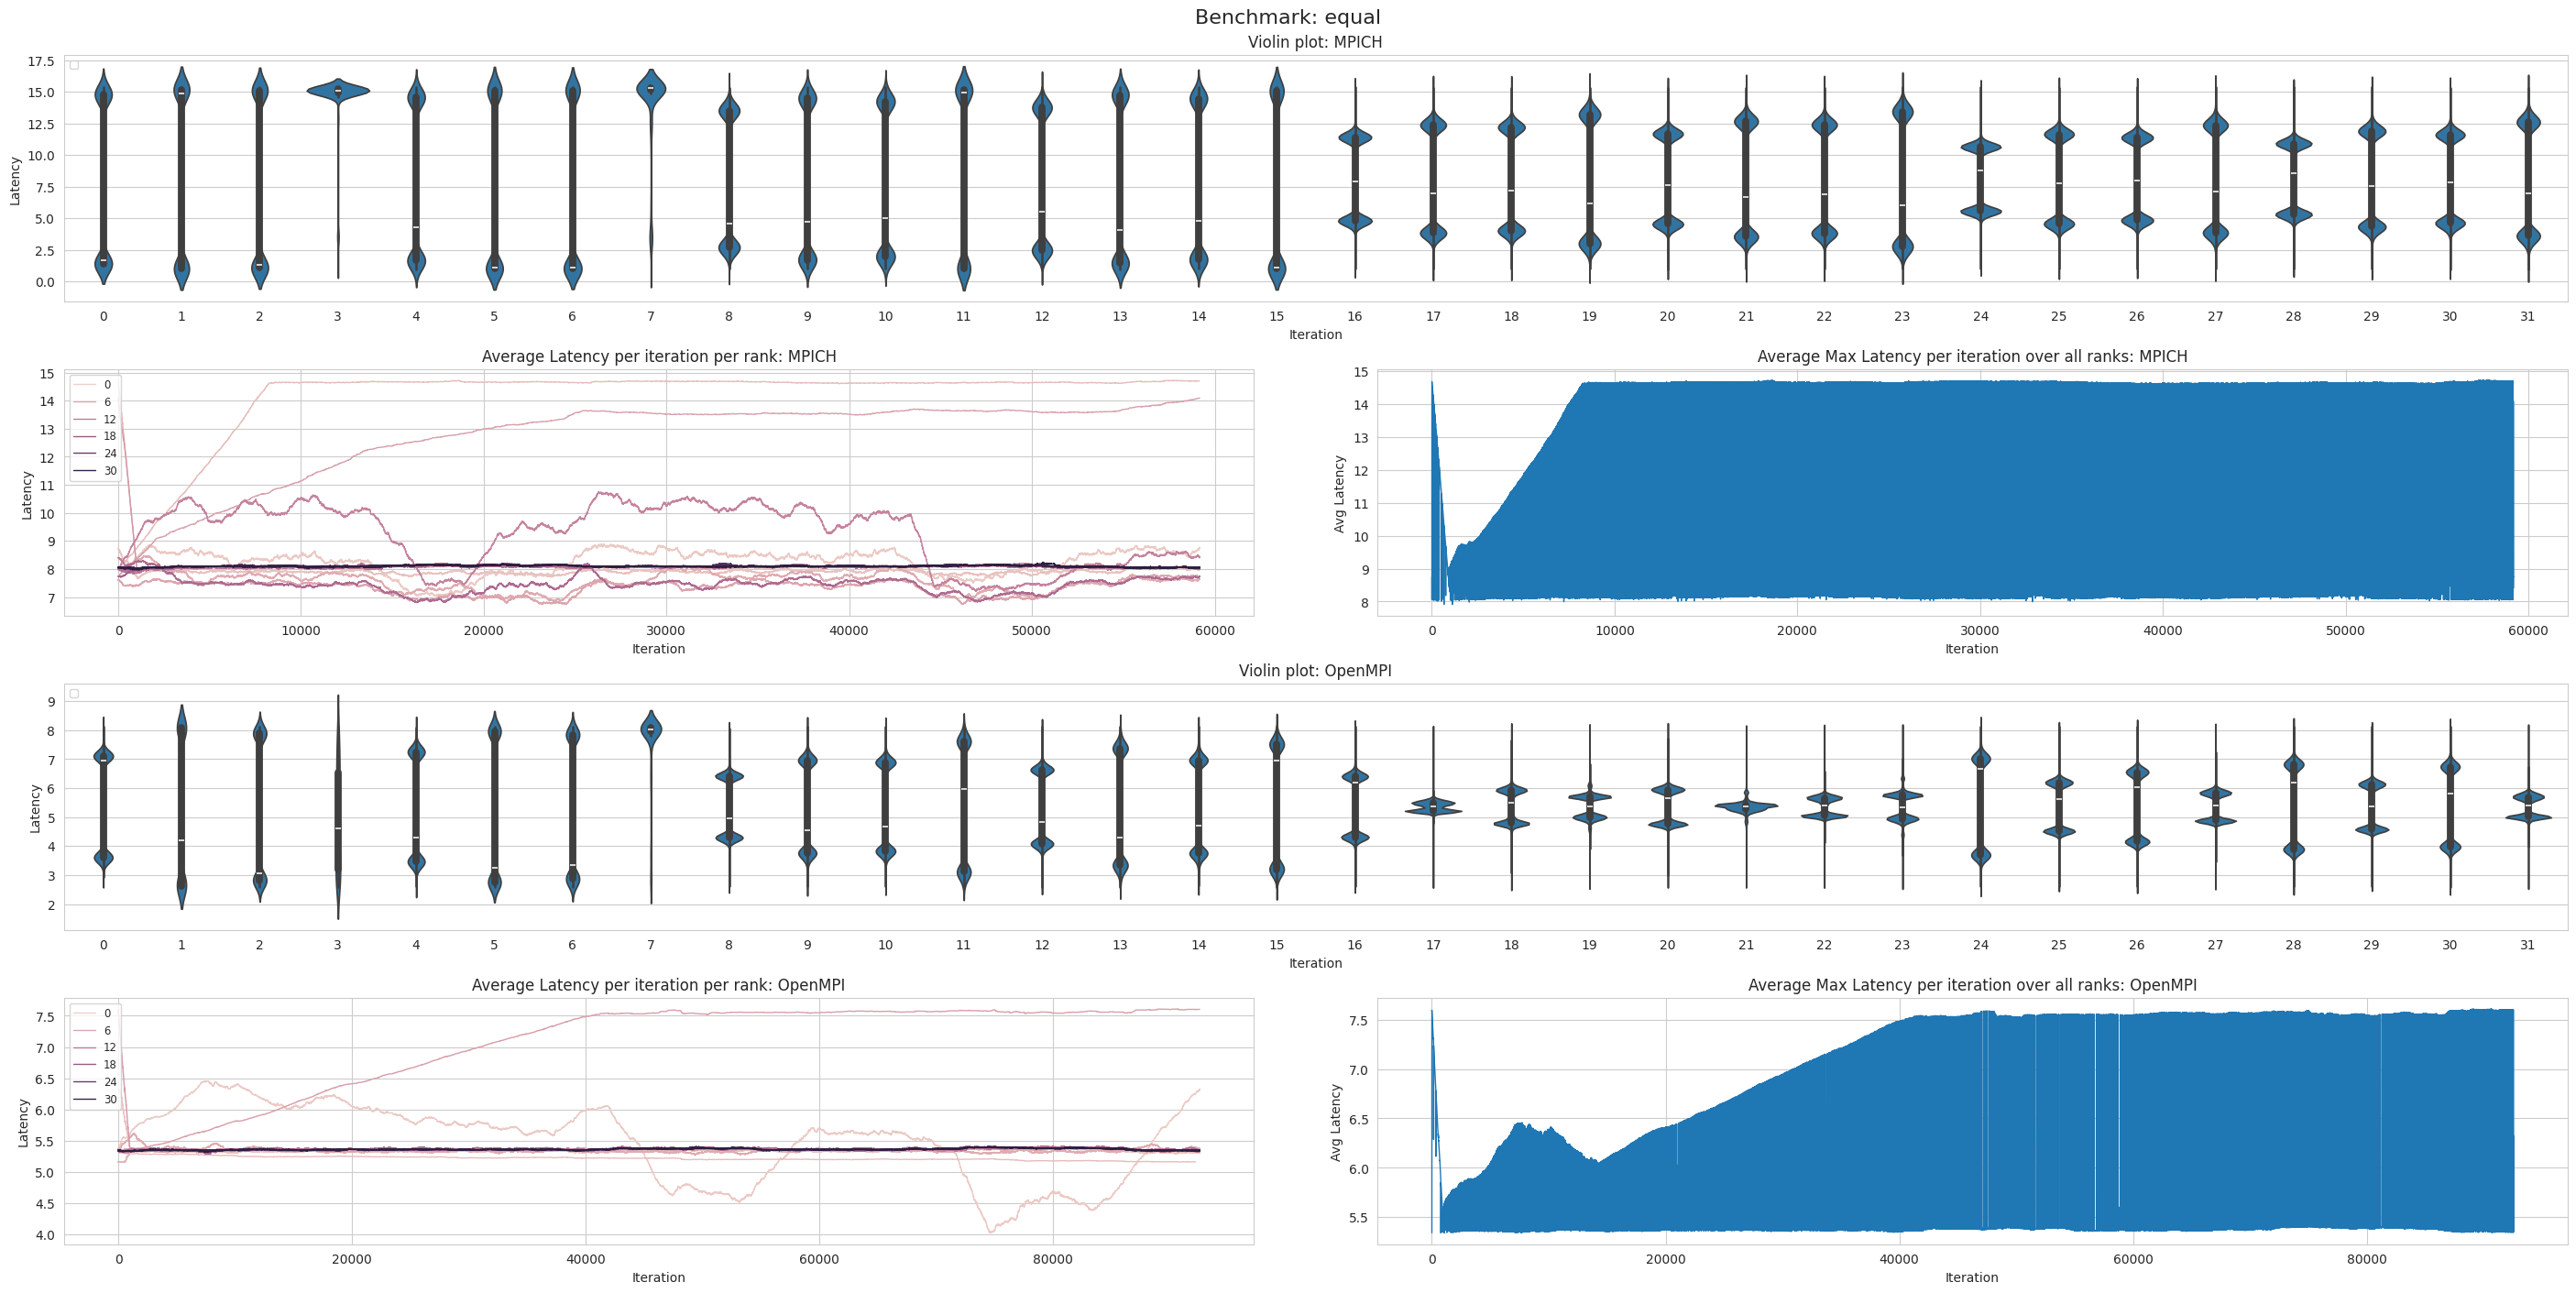

In [5]:
plot("equal")

# Alternating

``` json
{
    "test_name": "scatterv-alternating",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "alternating",
        "params": {
            "nproc": 32,
            "avg": 3
        }
    }
}
```


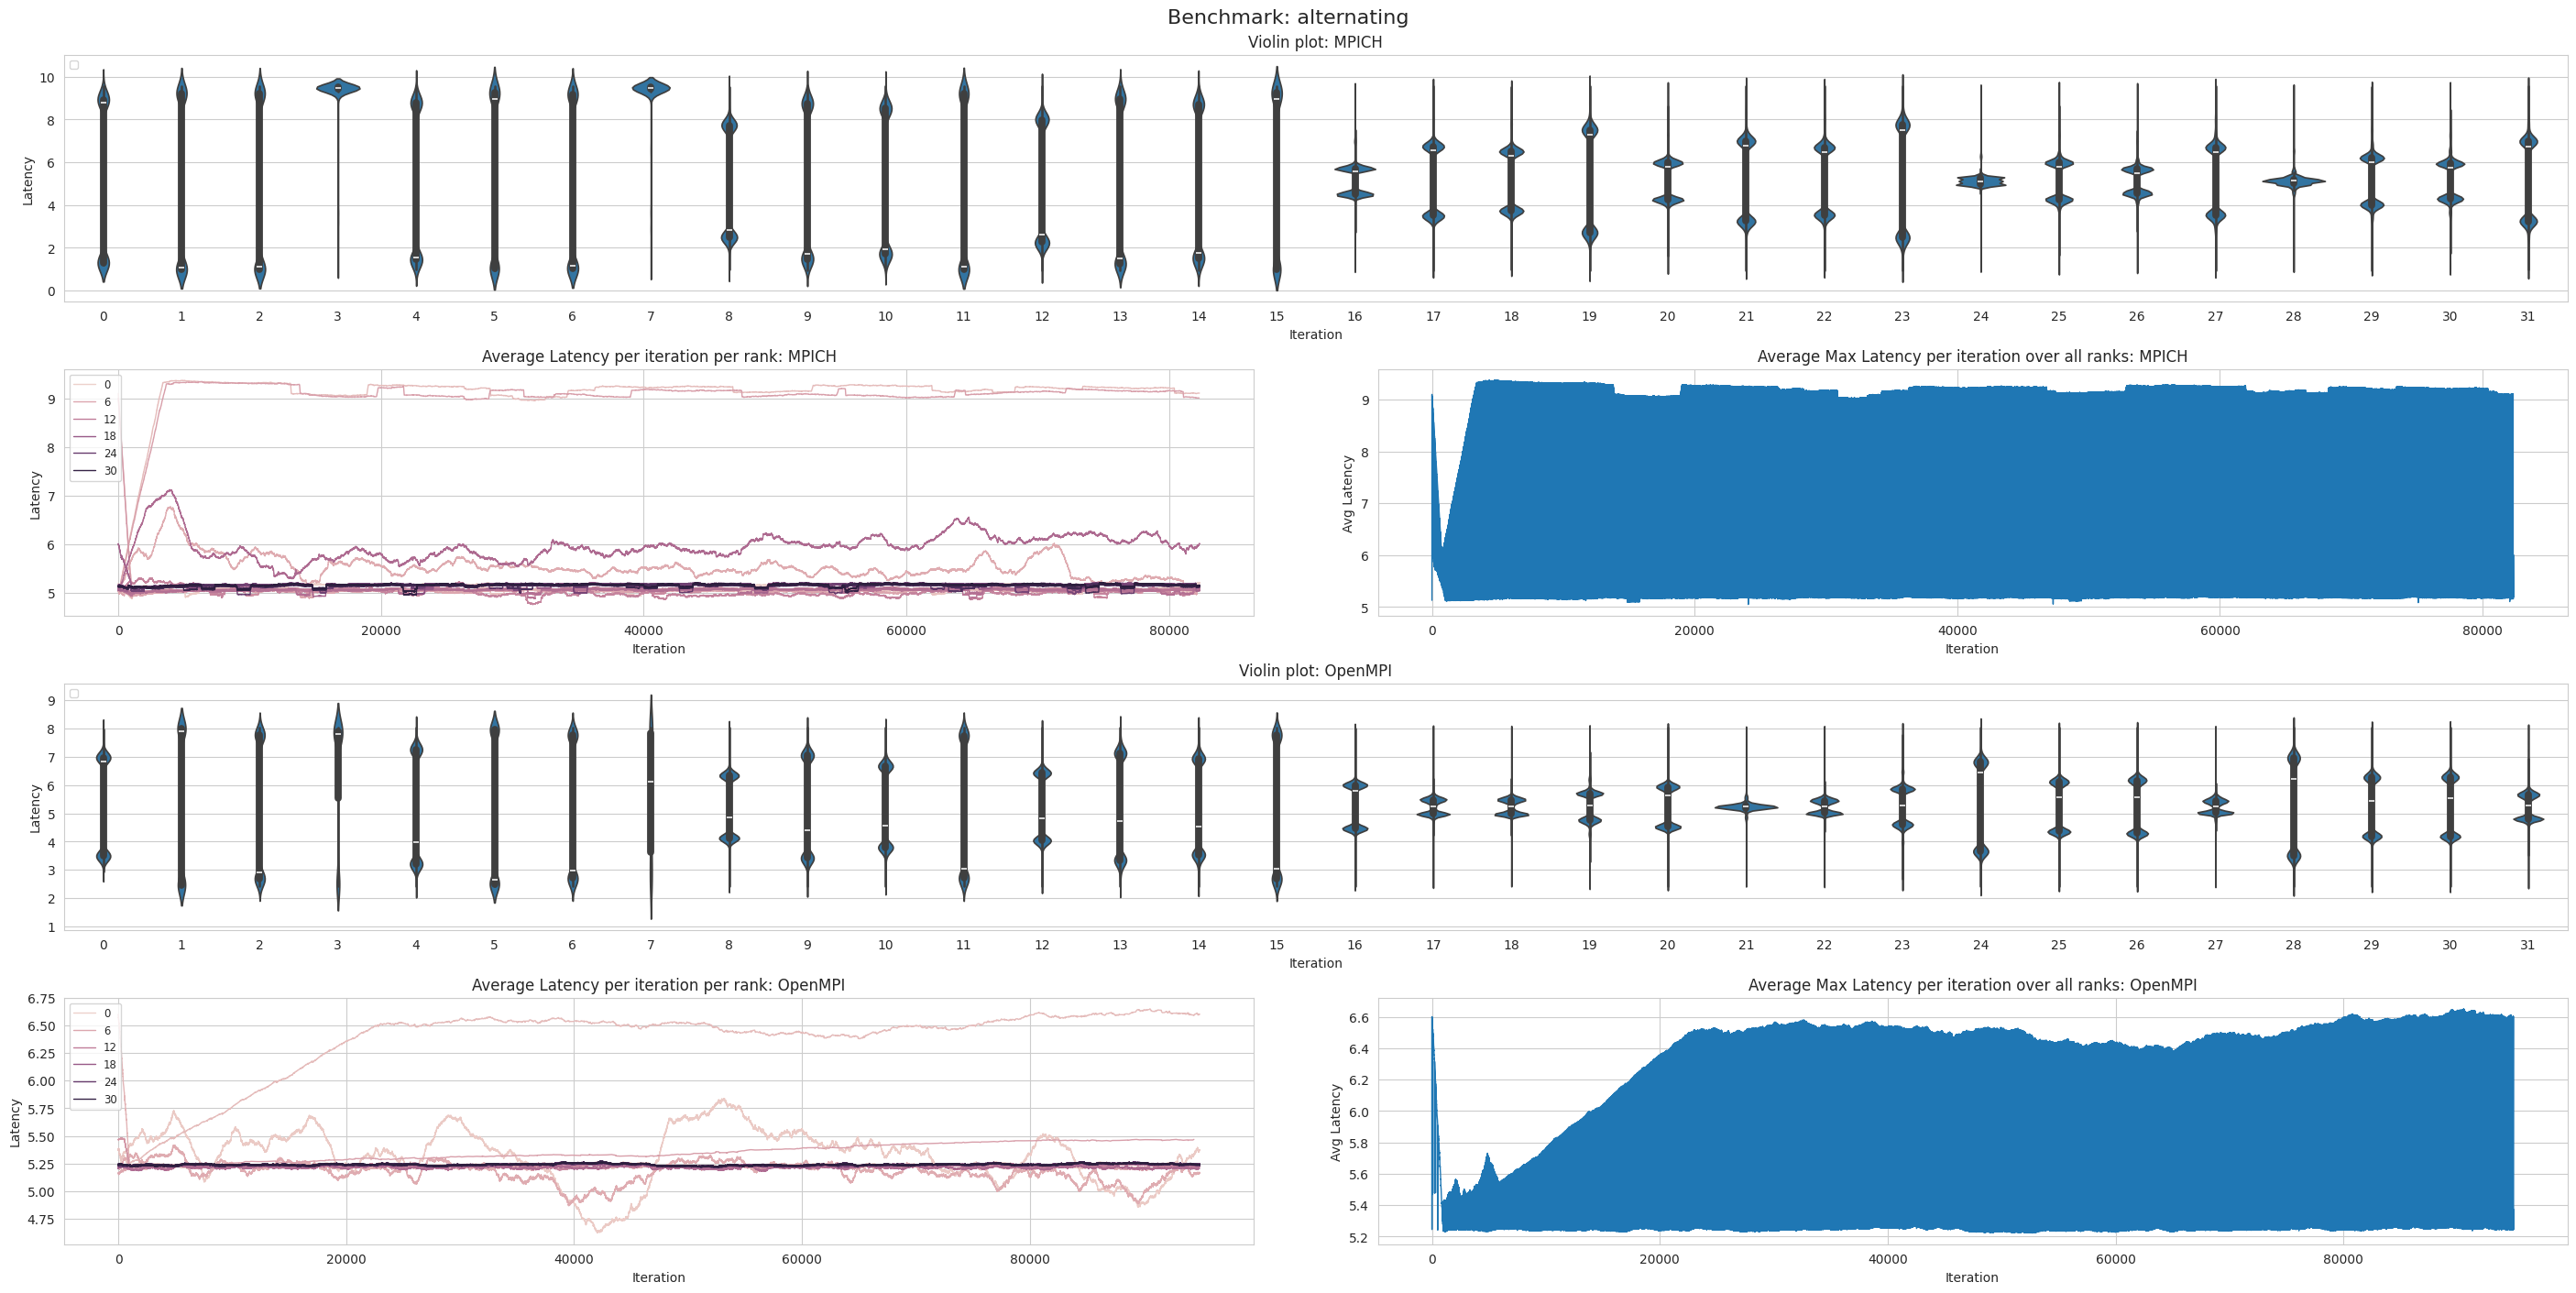

In [6]:
plot("alternating")

# Normal

``` json
{
    "test_name": "scatterv-normal",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "normal",
        "params": {
            "nproc": 32
        }
    }
}
``` 

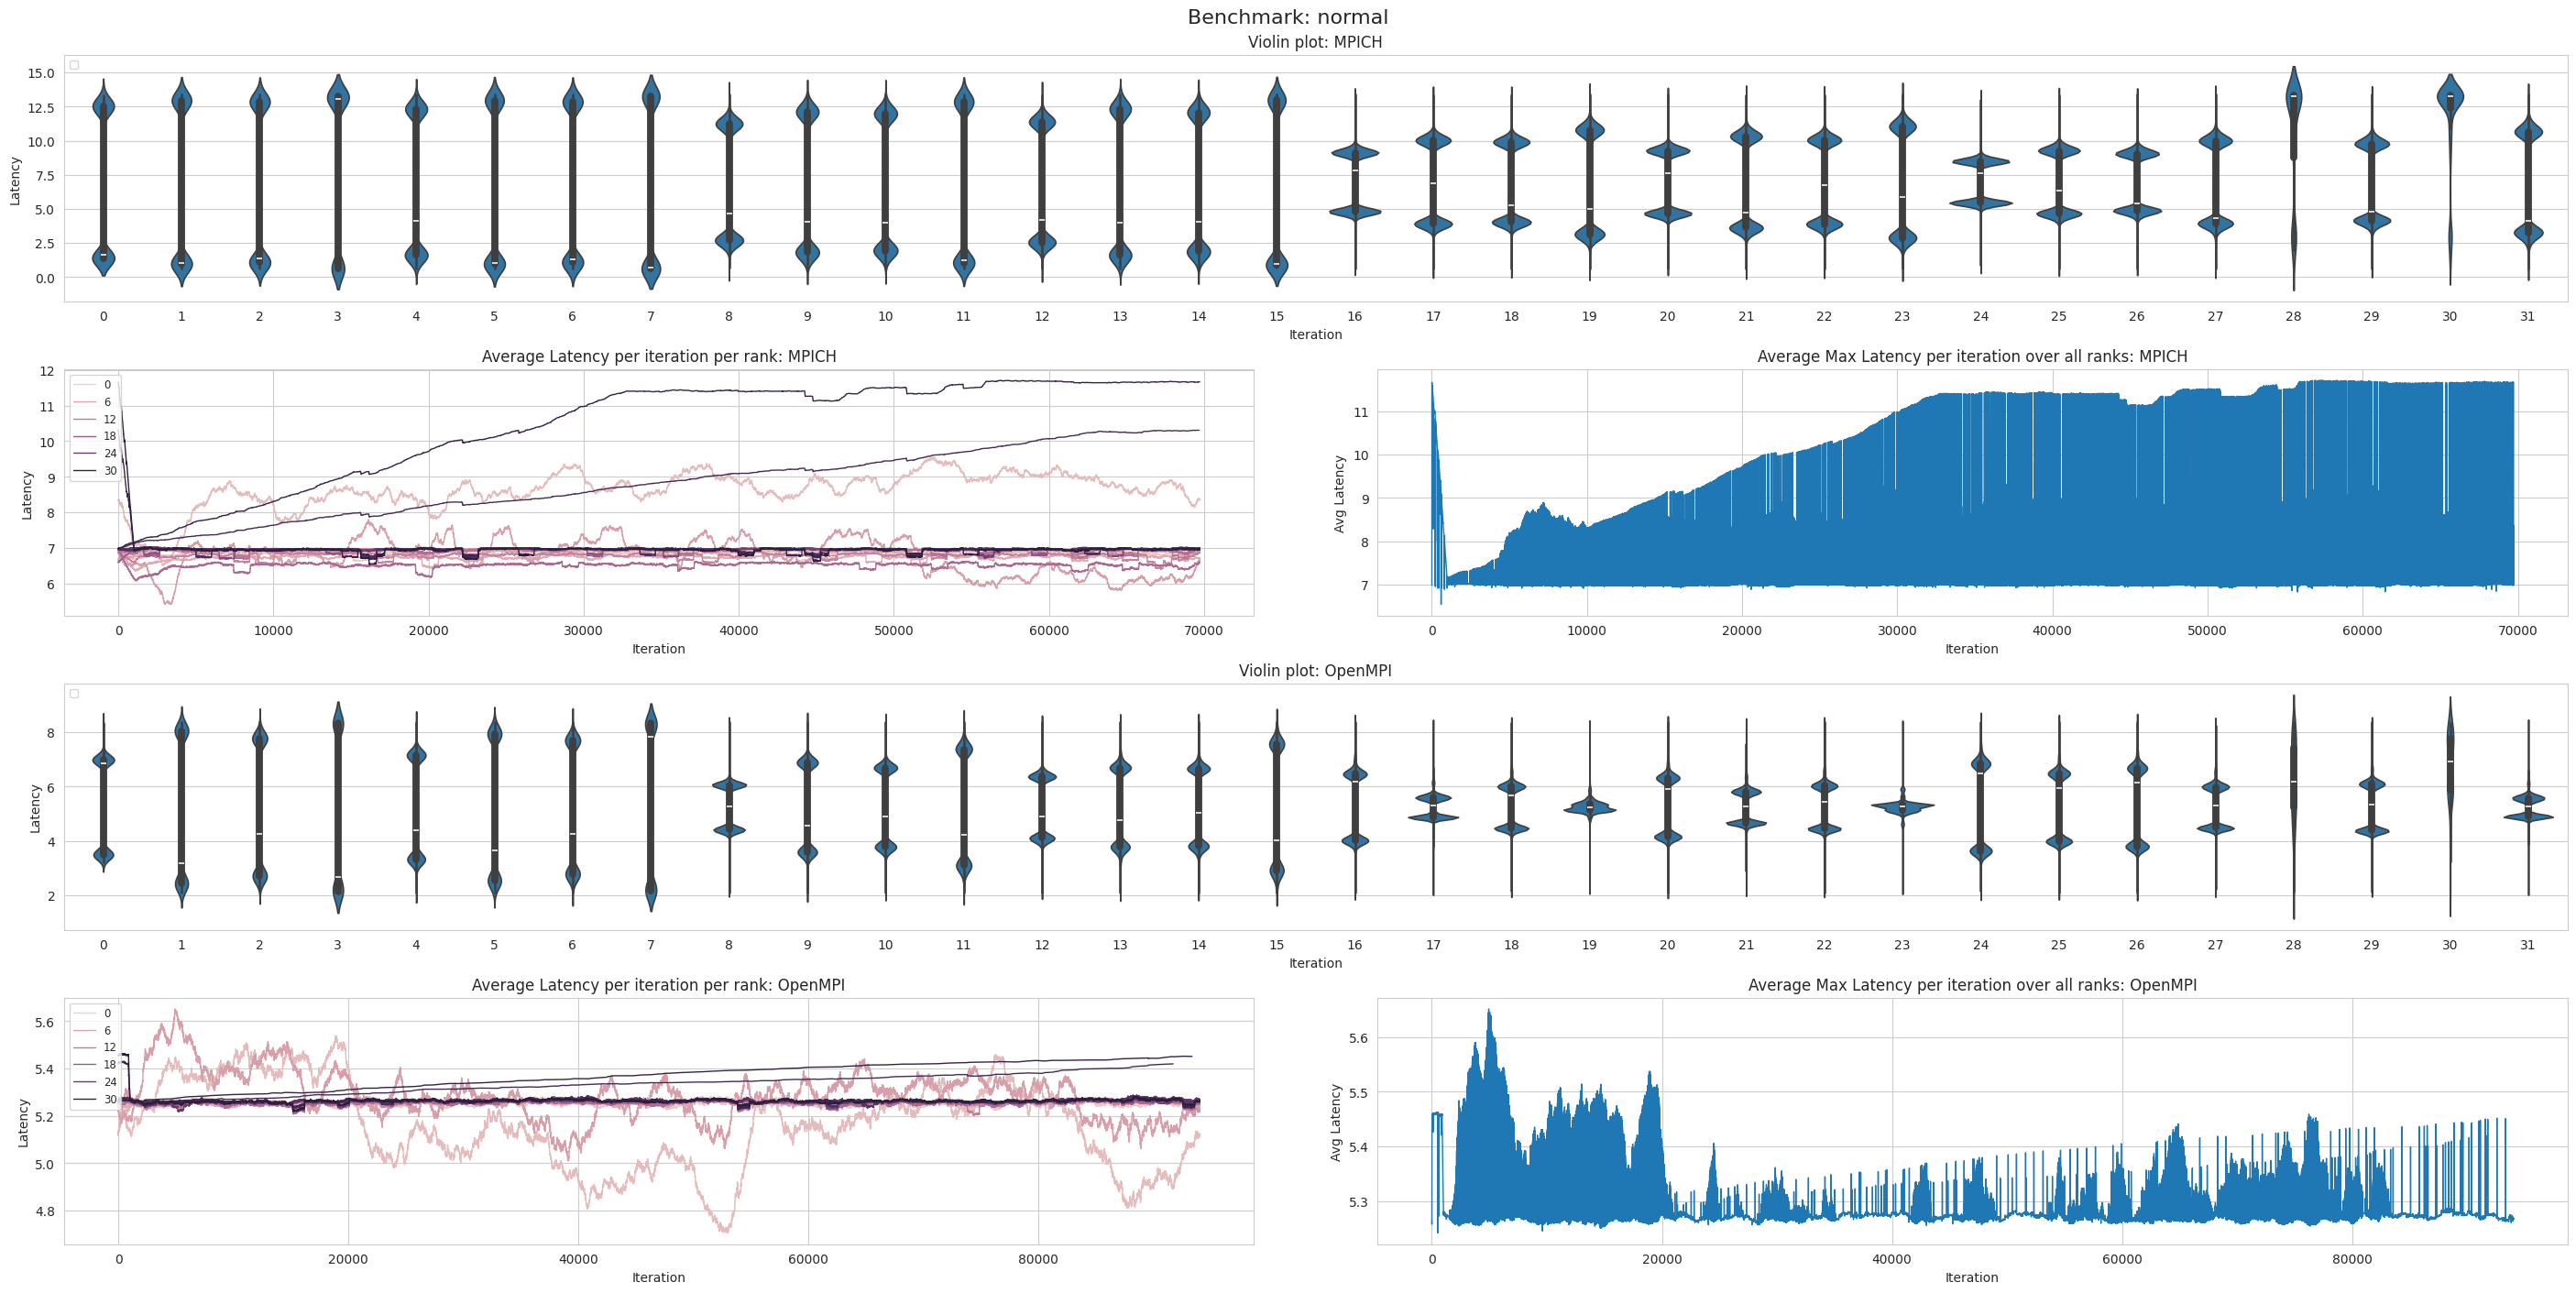

In [7]:
plot("normal")

# Exponential

``` json
{
    "test_name": "scatterv-exponential",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "exponential",
        "params": {
            "nproc": 32
        }
    }
}
```

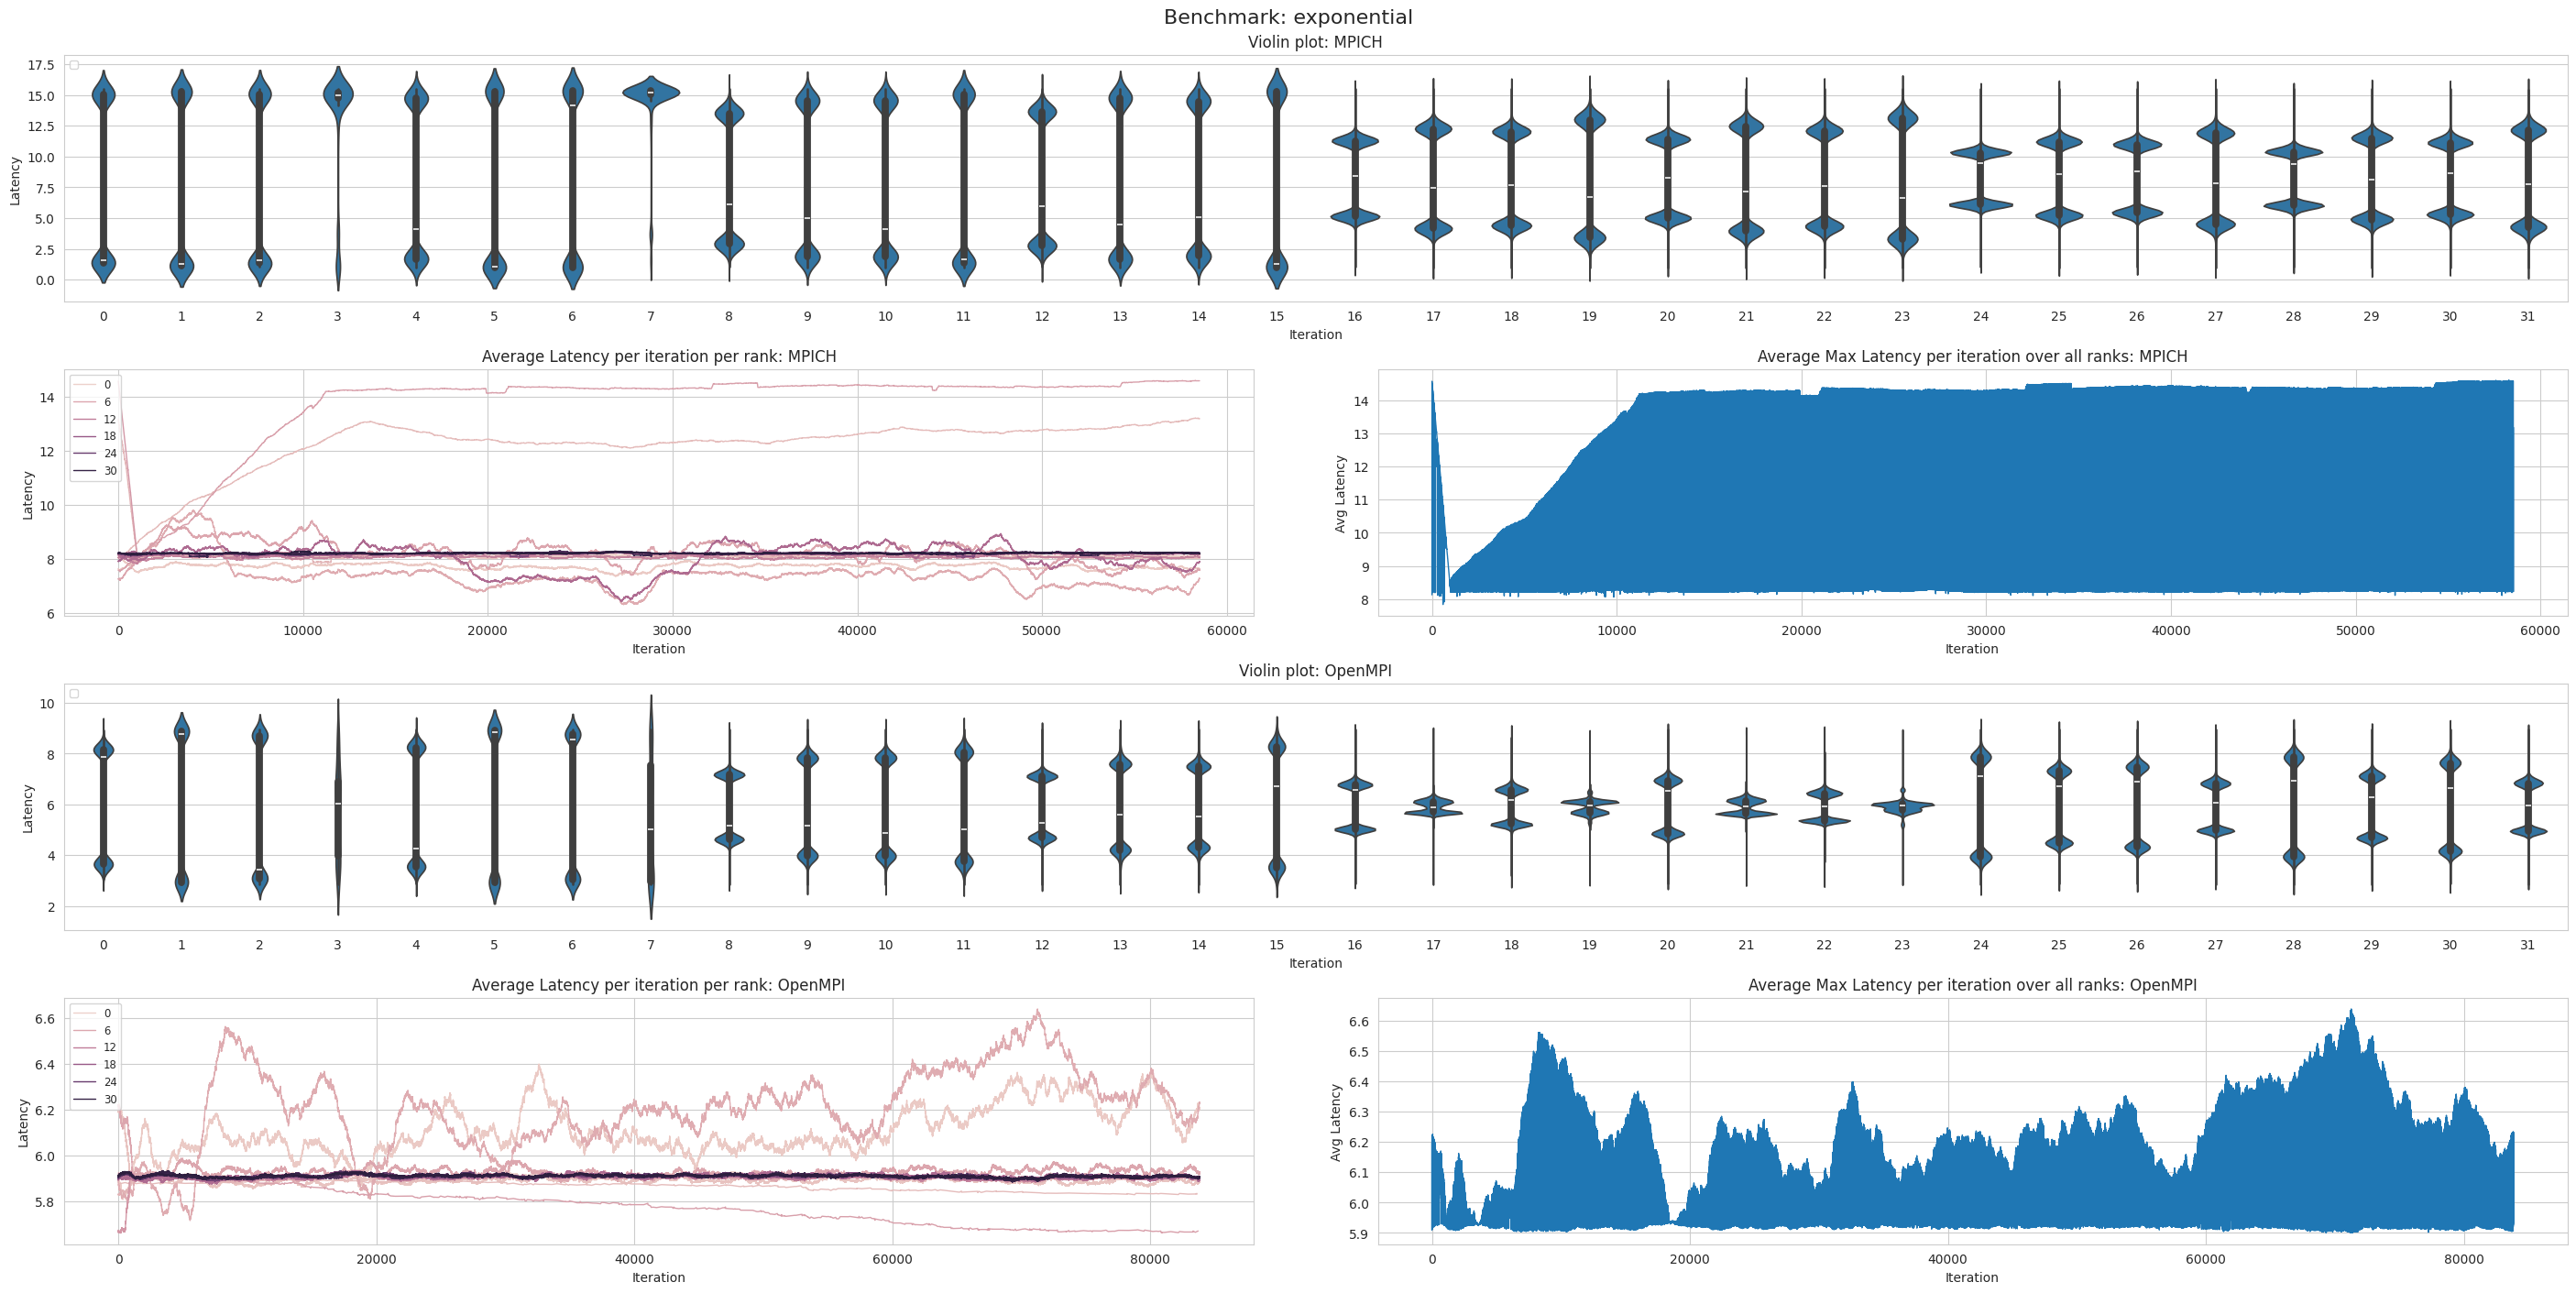

In [112]:
plot("exponential")

        
# Increasing

``` json
{
    "test_name": "scatterv-increasing",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "increasing",
        "params": {
            "nproc": 32,
            "avg": 3
        }
    }
}
``` 

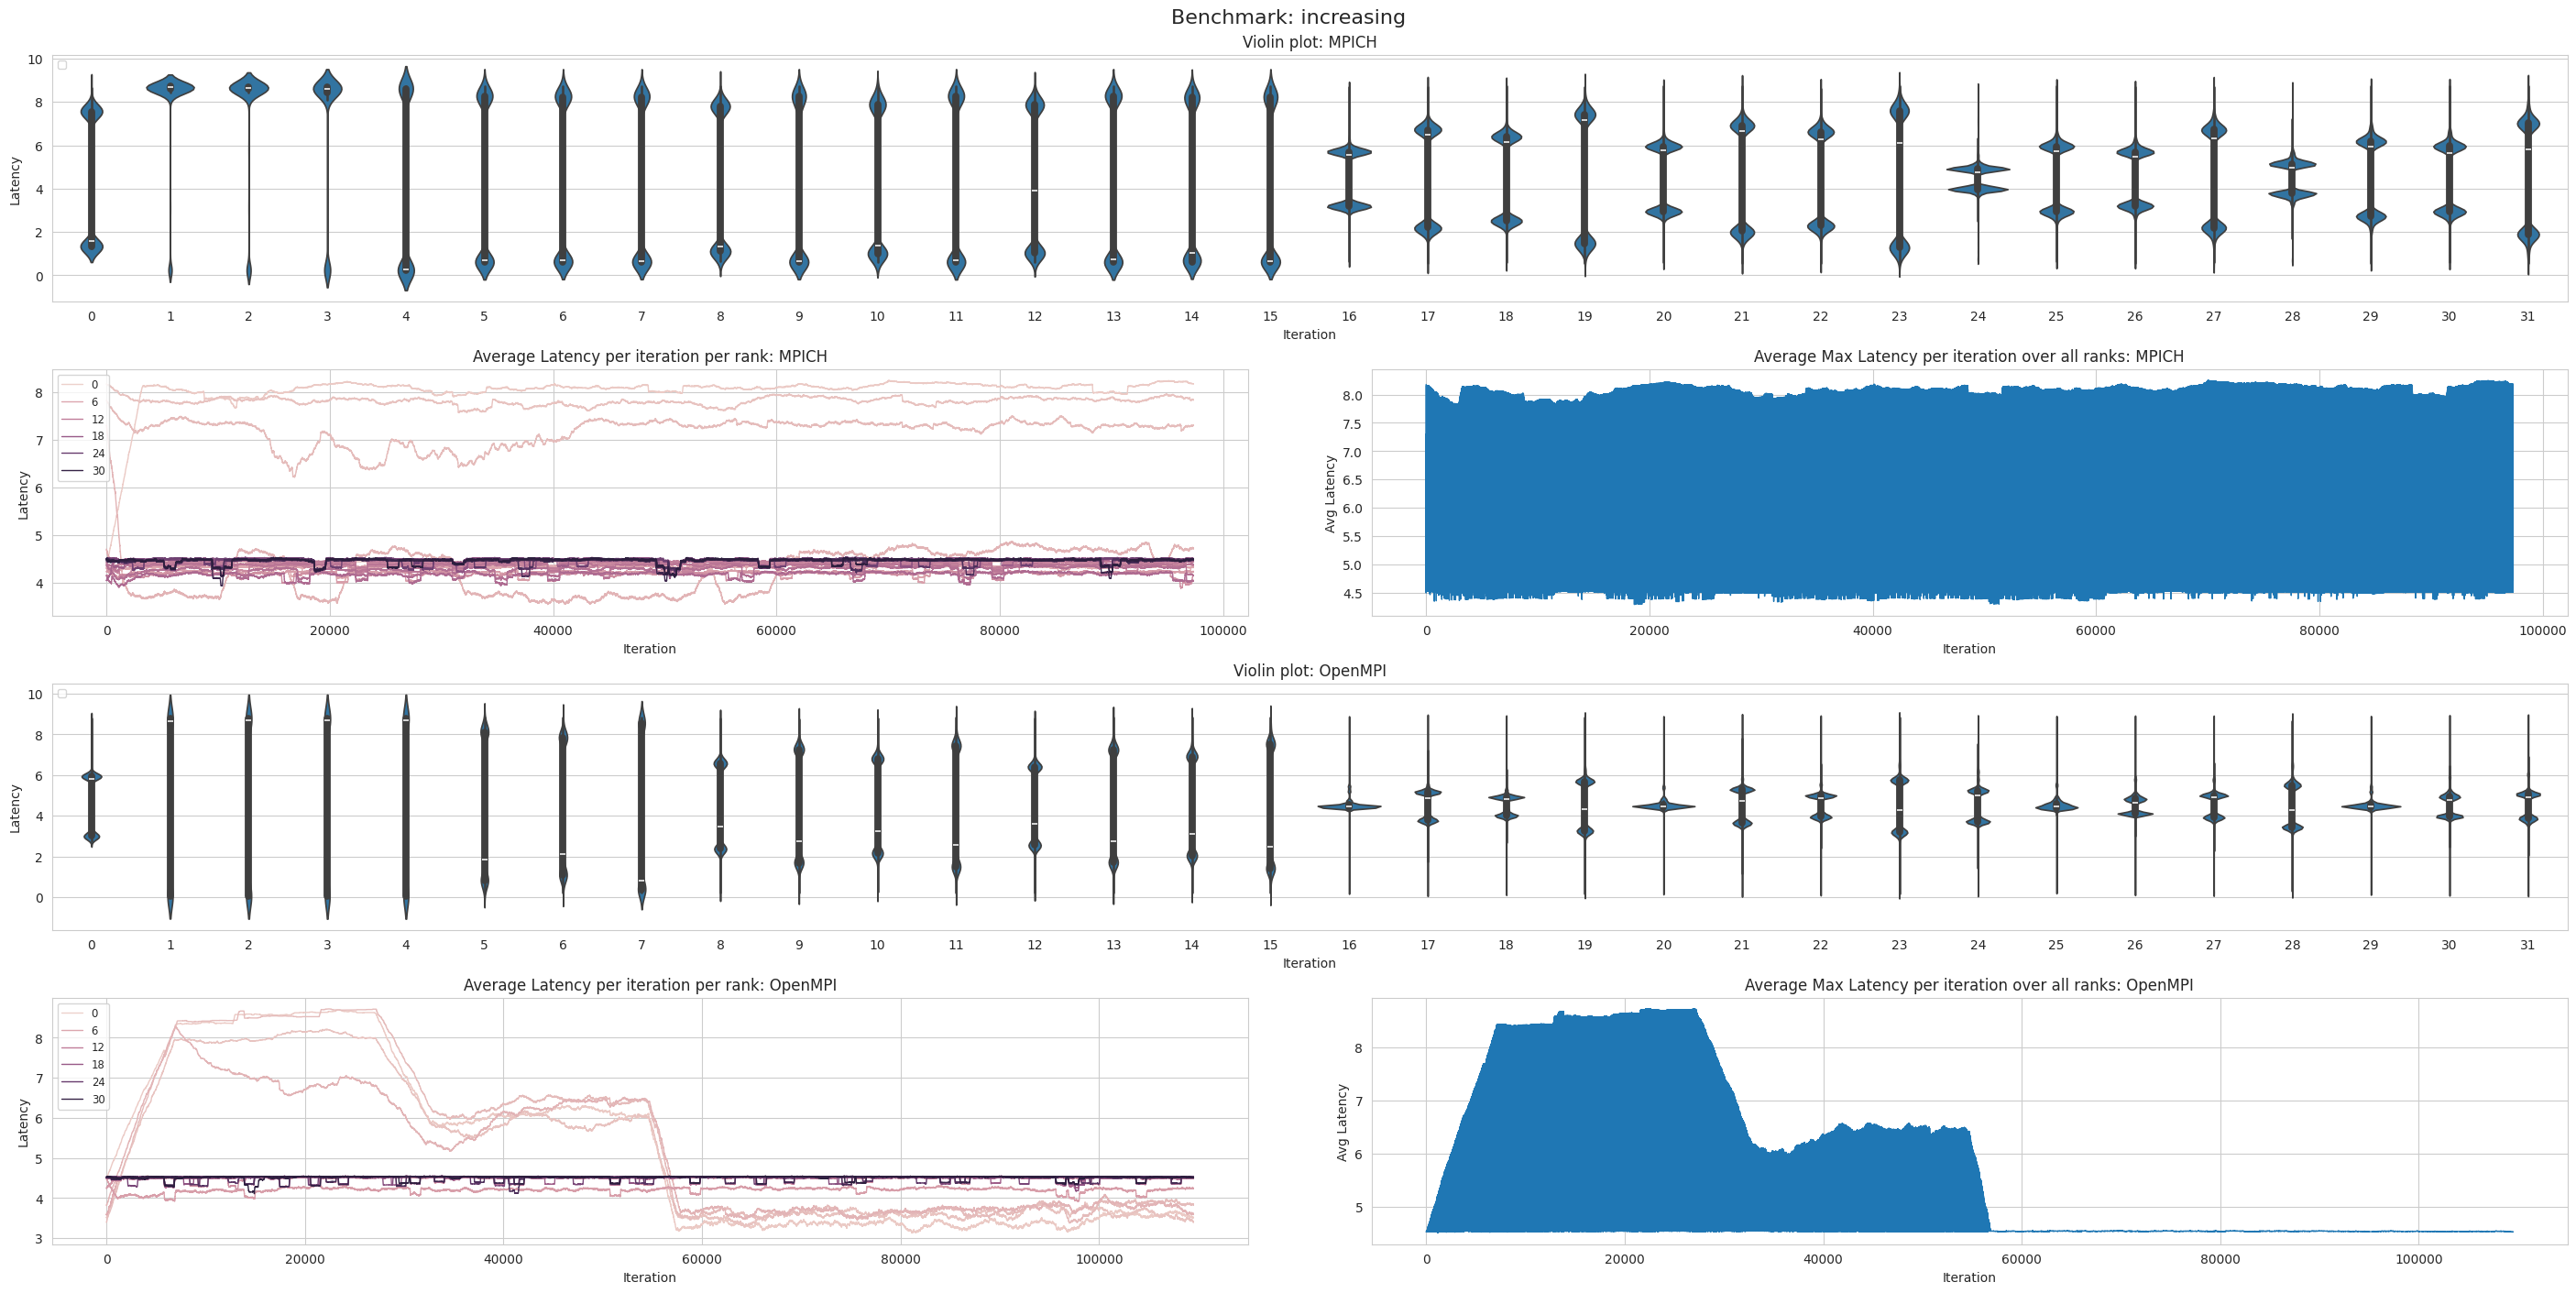

In [8]:
plot("increasing")

# Decreasing

``` json
{
    "test_name": "scatterv-decreasing",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "decreasing",
        "params": {
            "nproc": 32,
            "avg": 3
        }
    }
}
``` 

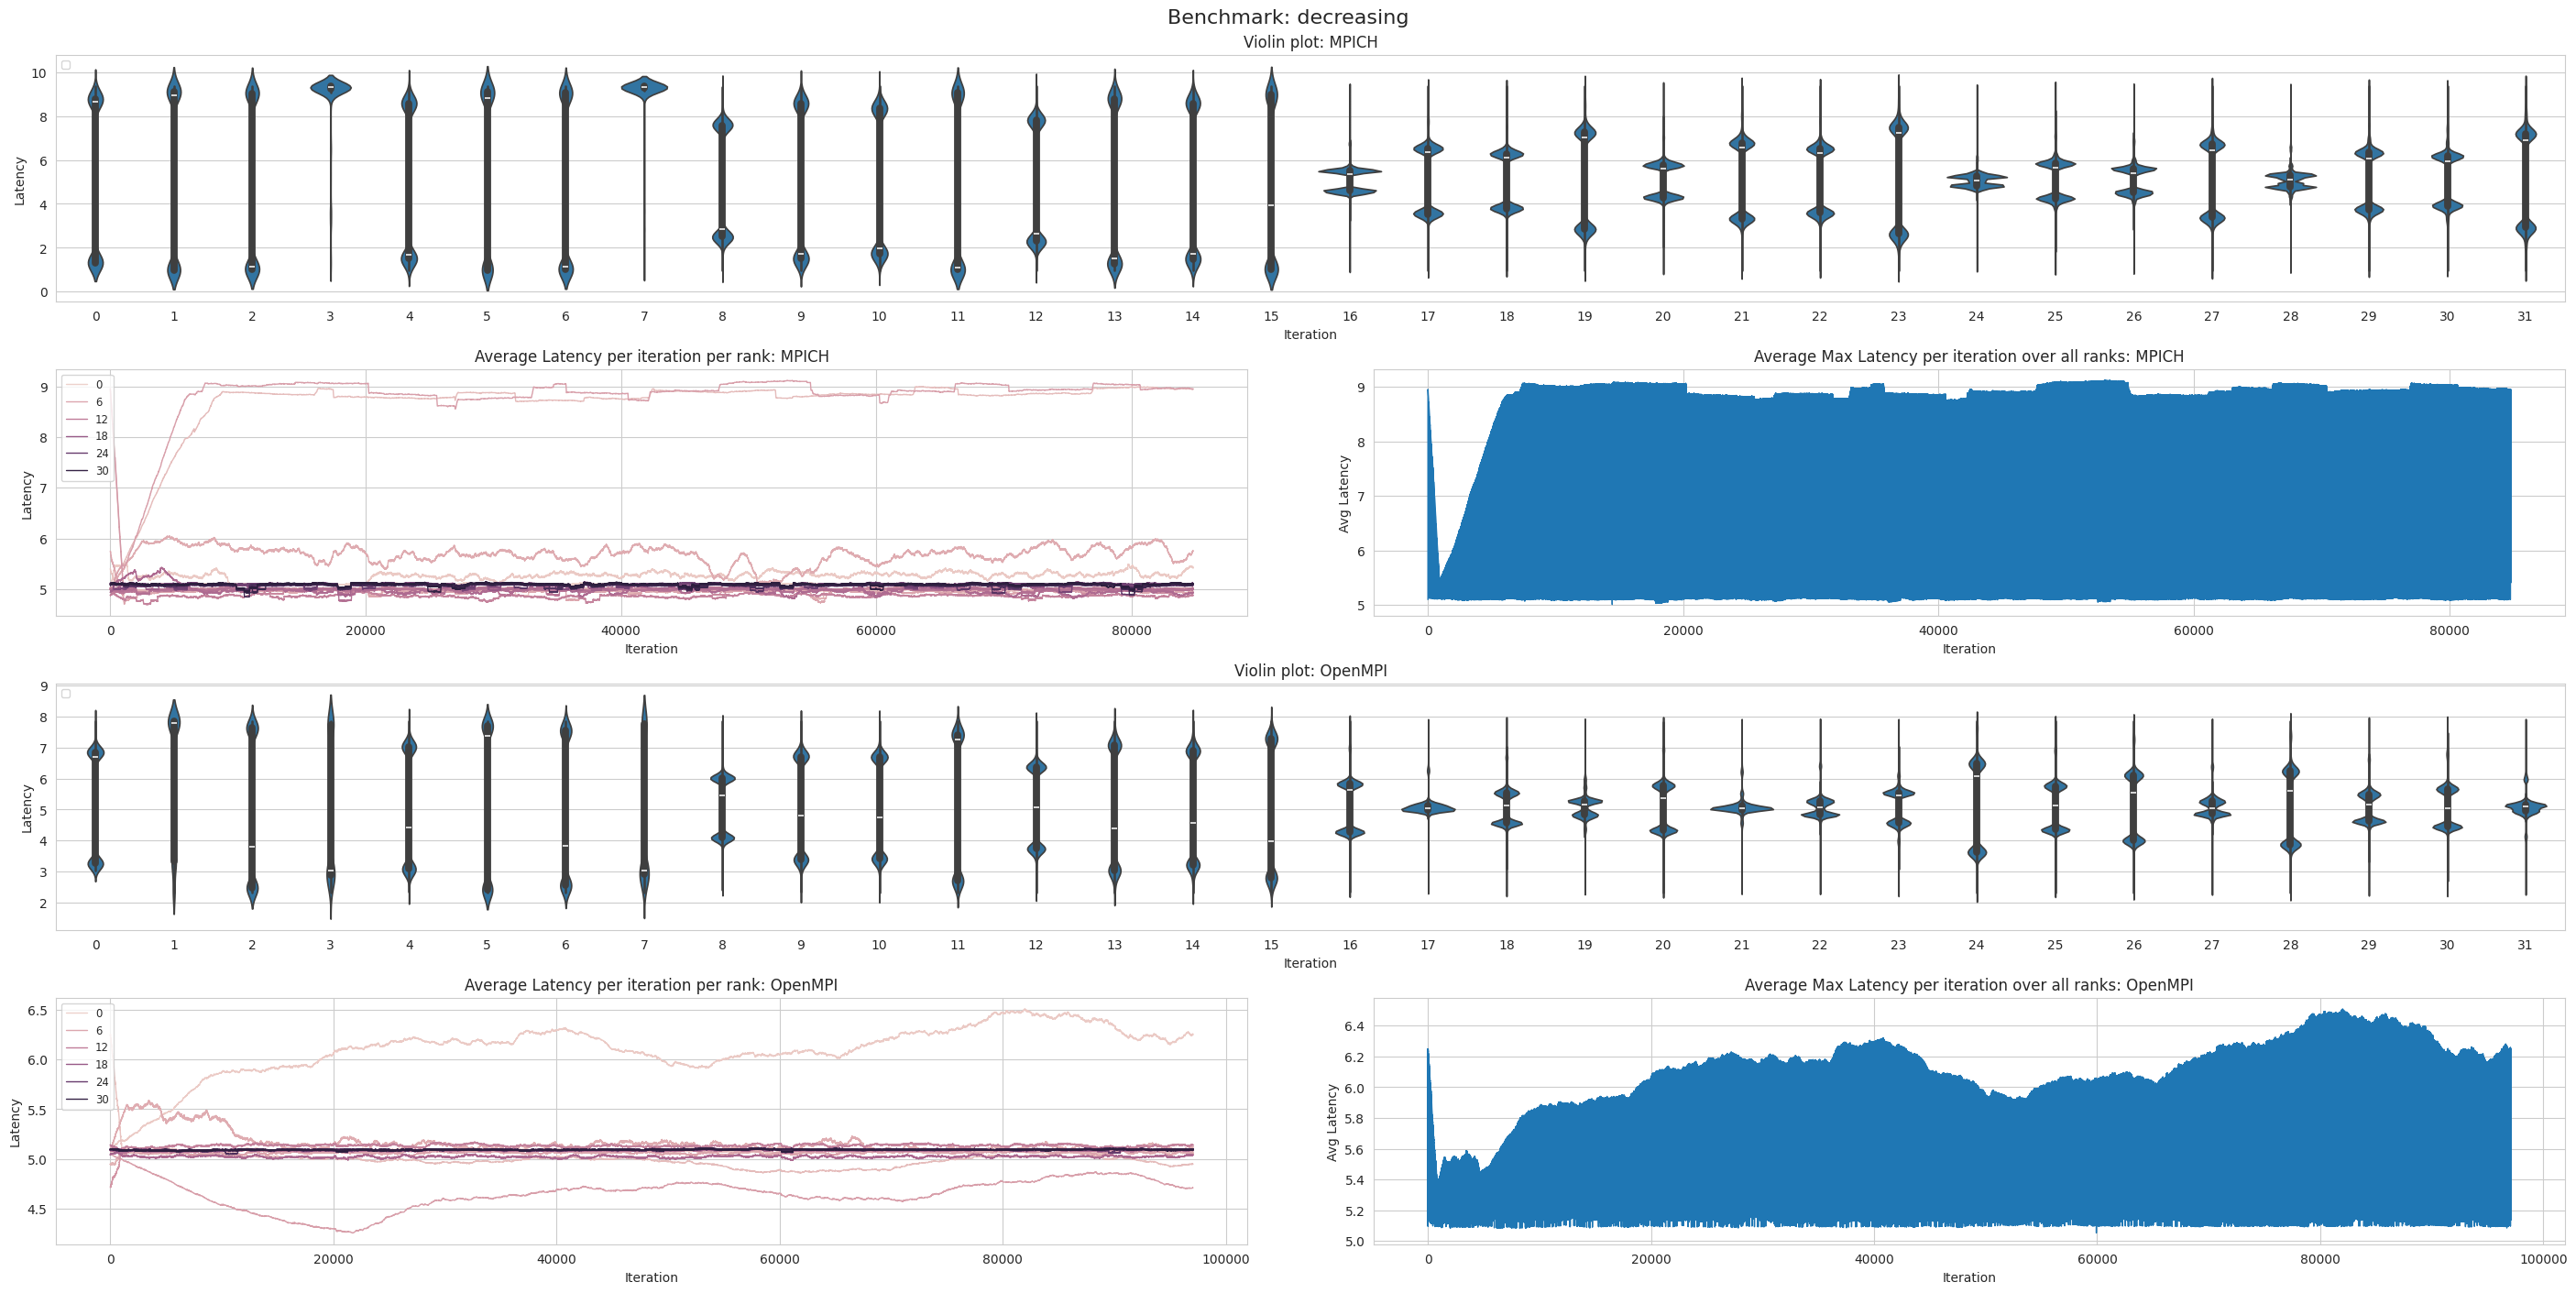

In [10]:
plot("decreasing")

# Zipfian

``` json
{
    "test_name": "scatterv-zipfian",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "zipfian",
        "params": {
            "nproc": 32
        }
    }
}
``` 

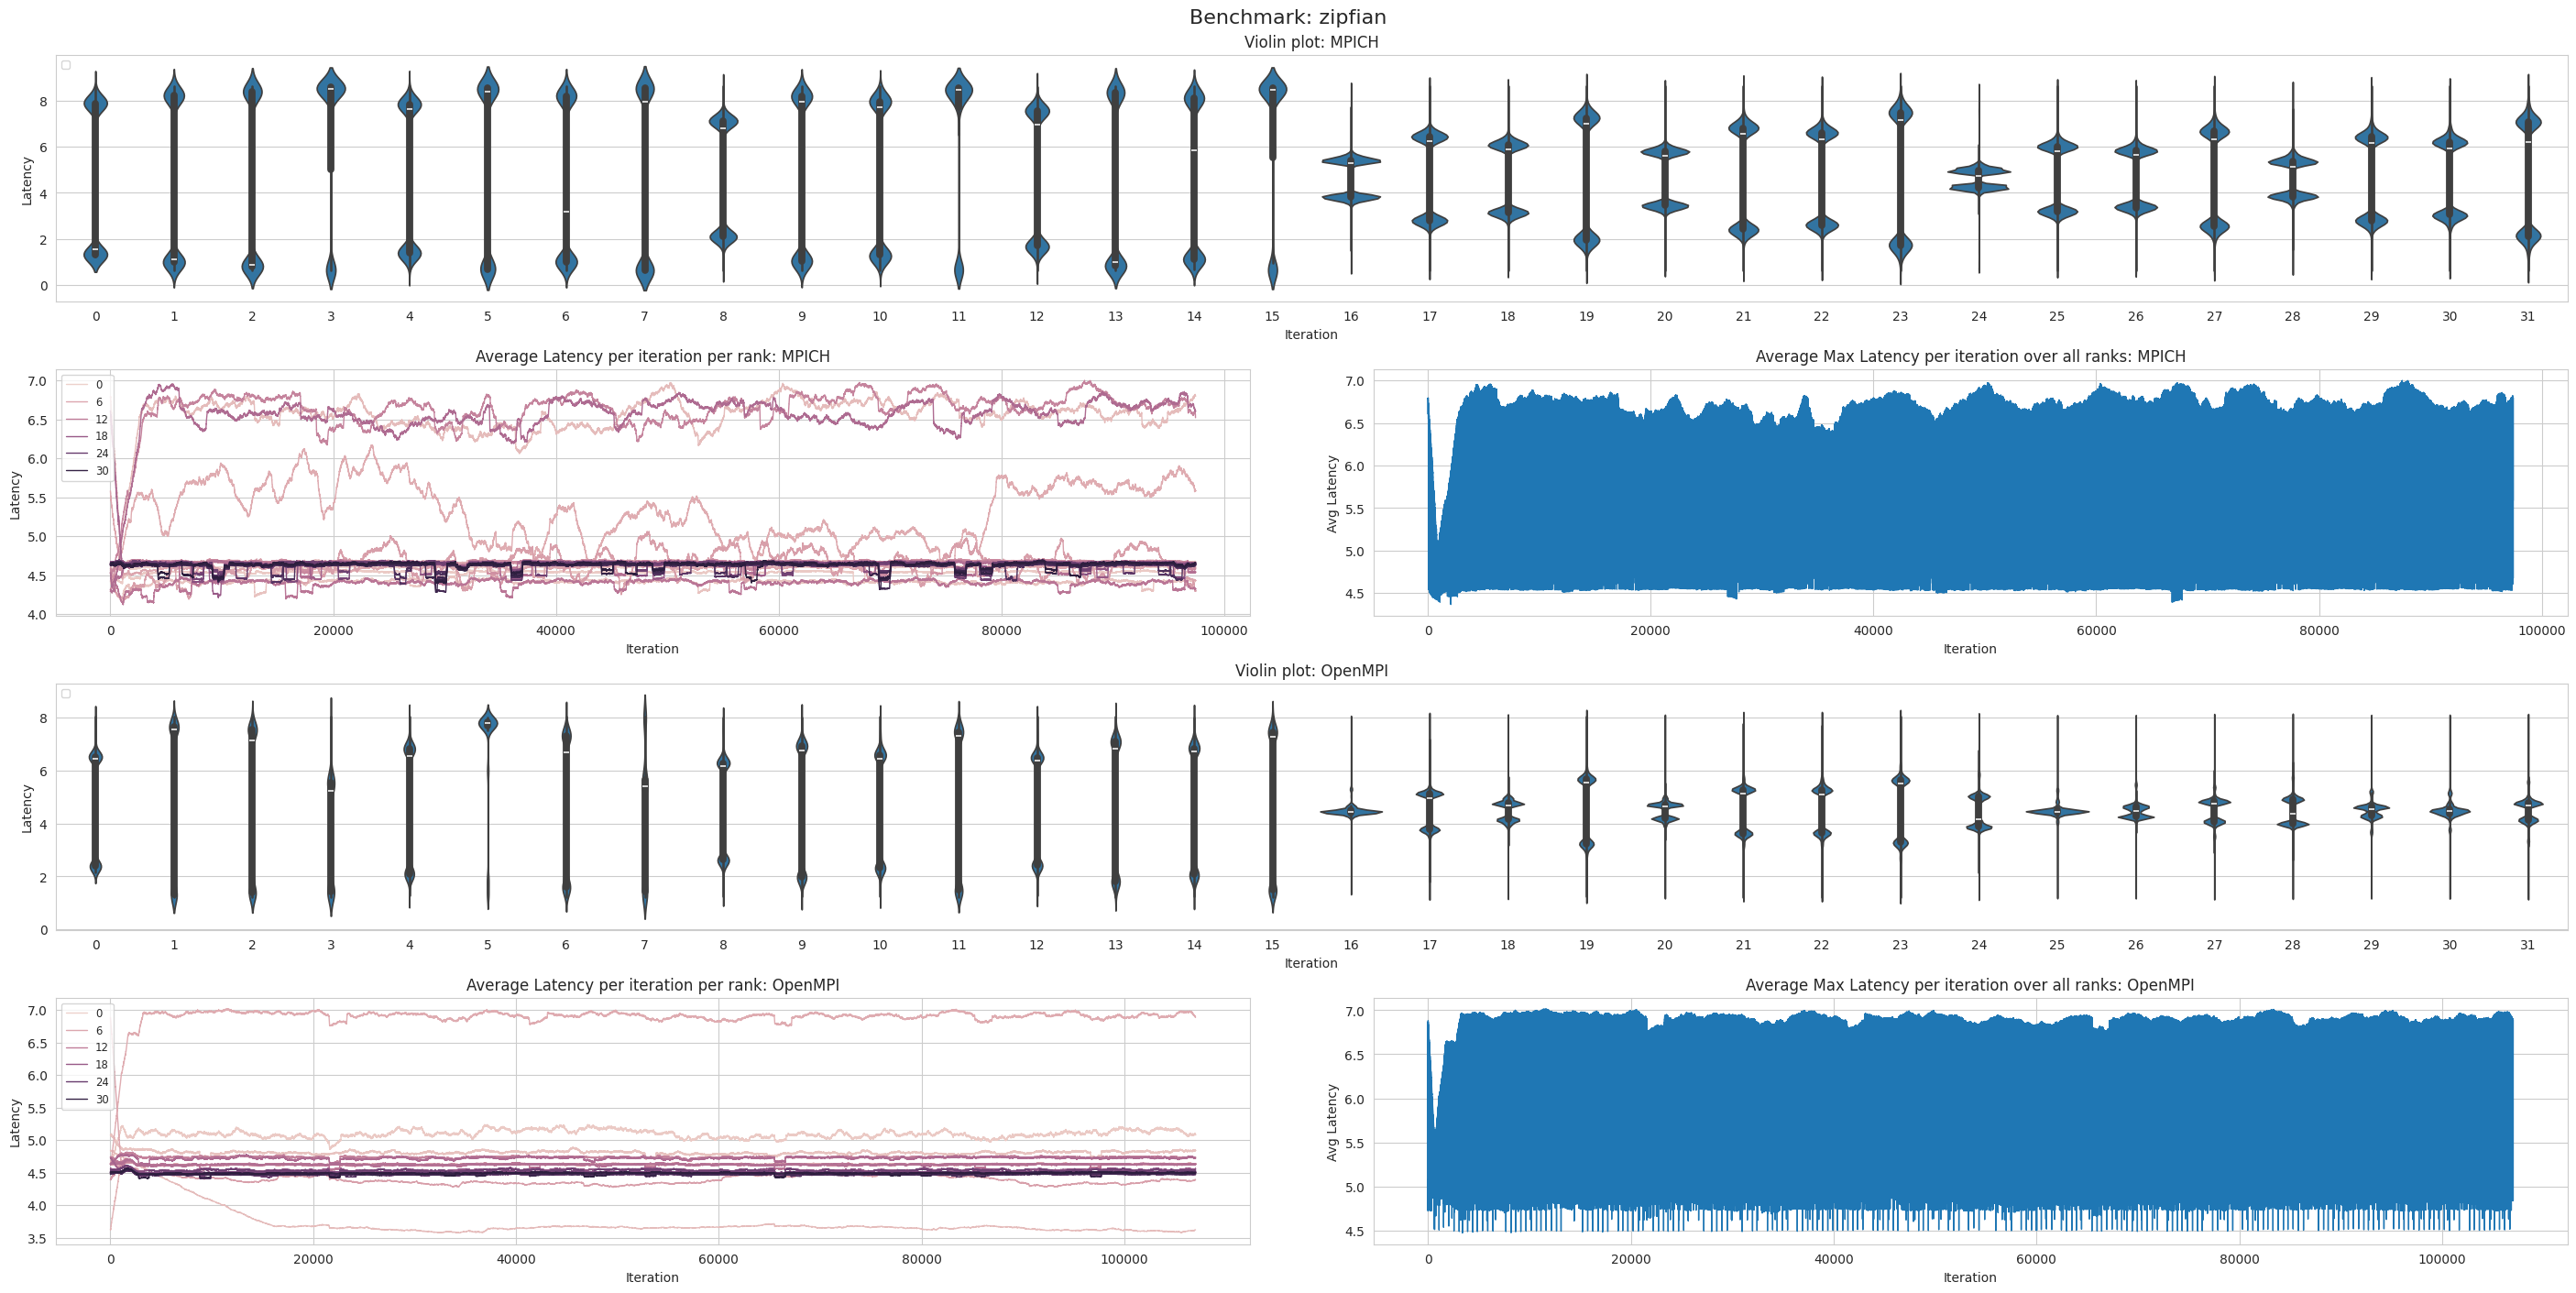

In [11]:
plot("zipfian")

# Uniform

``` json
{
    "test_name": "scatterv-uniform",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "uniform",
        "params": {
            "nproc": 32,
            "avg": 3
        }
    }
}
```

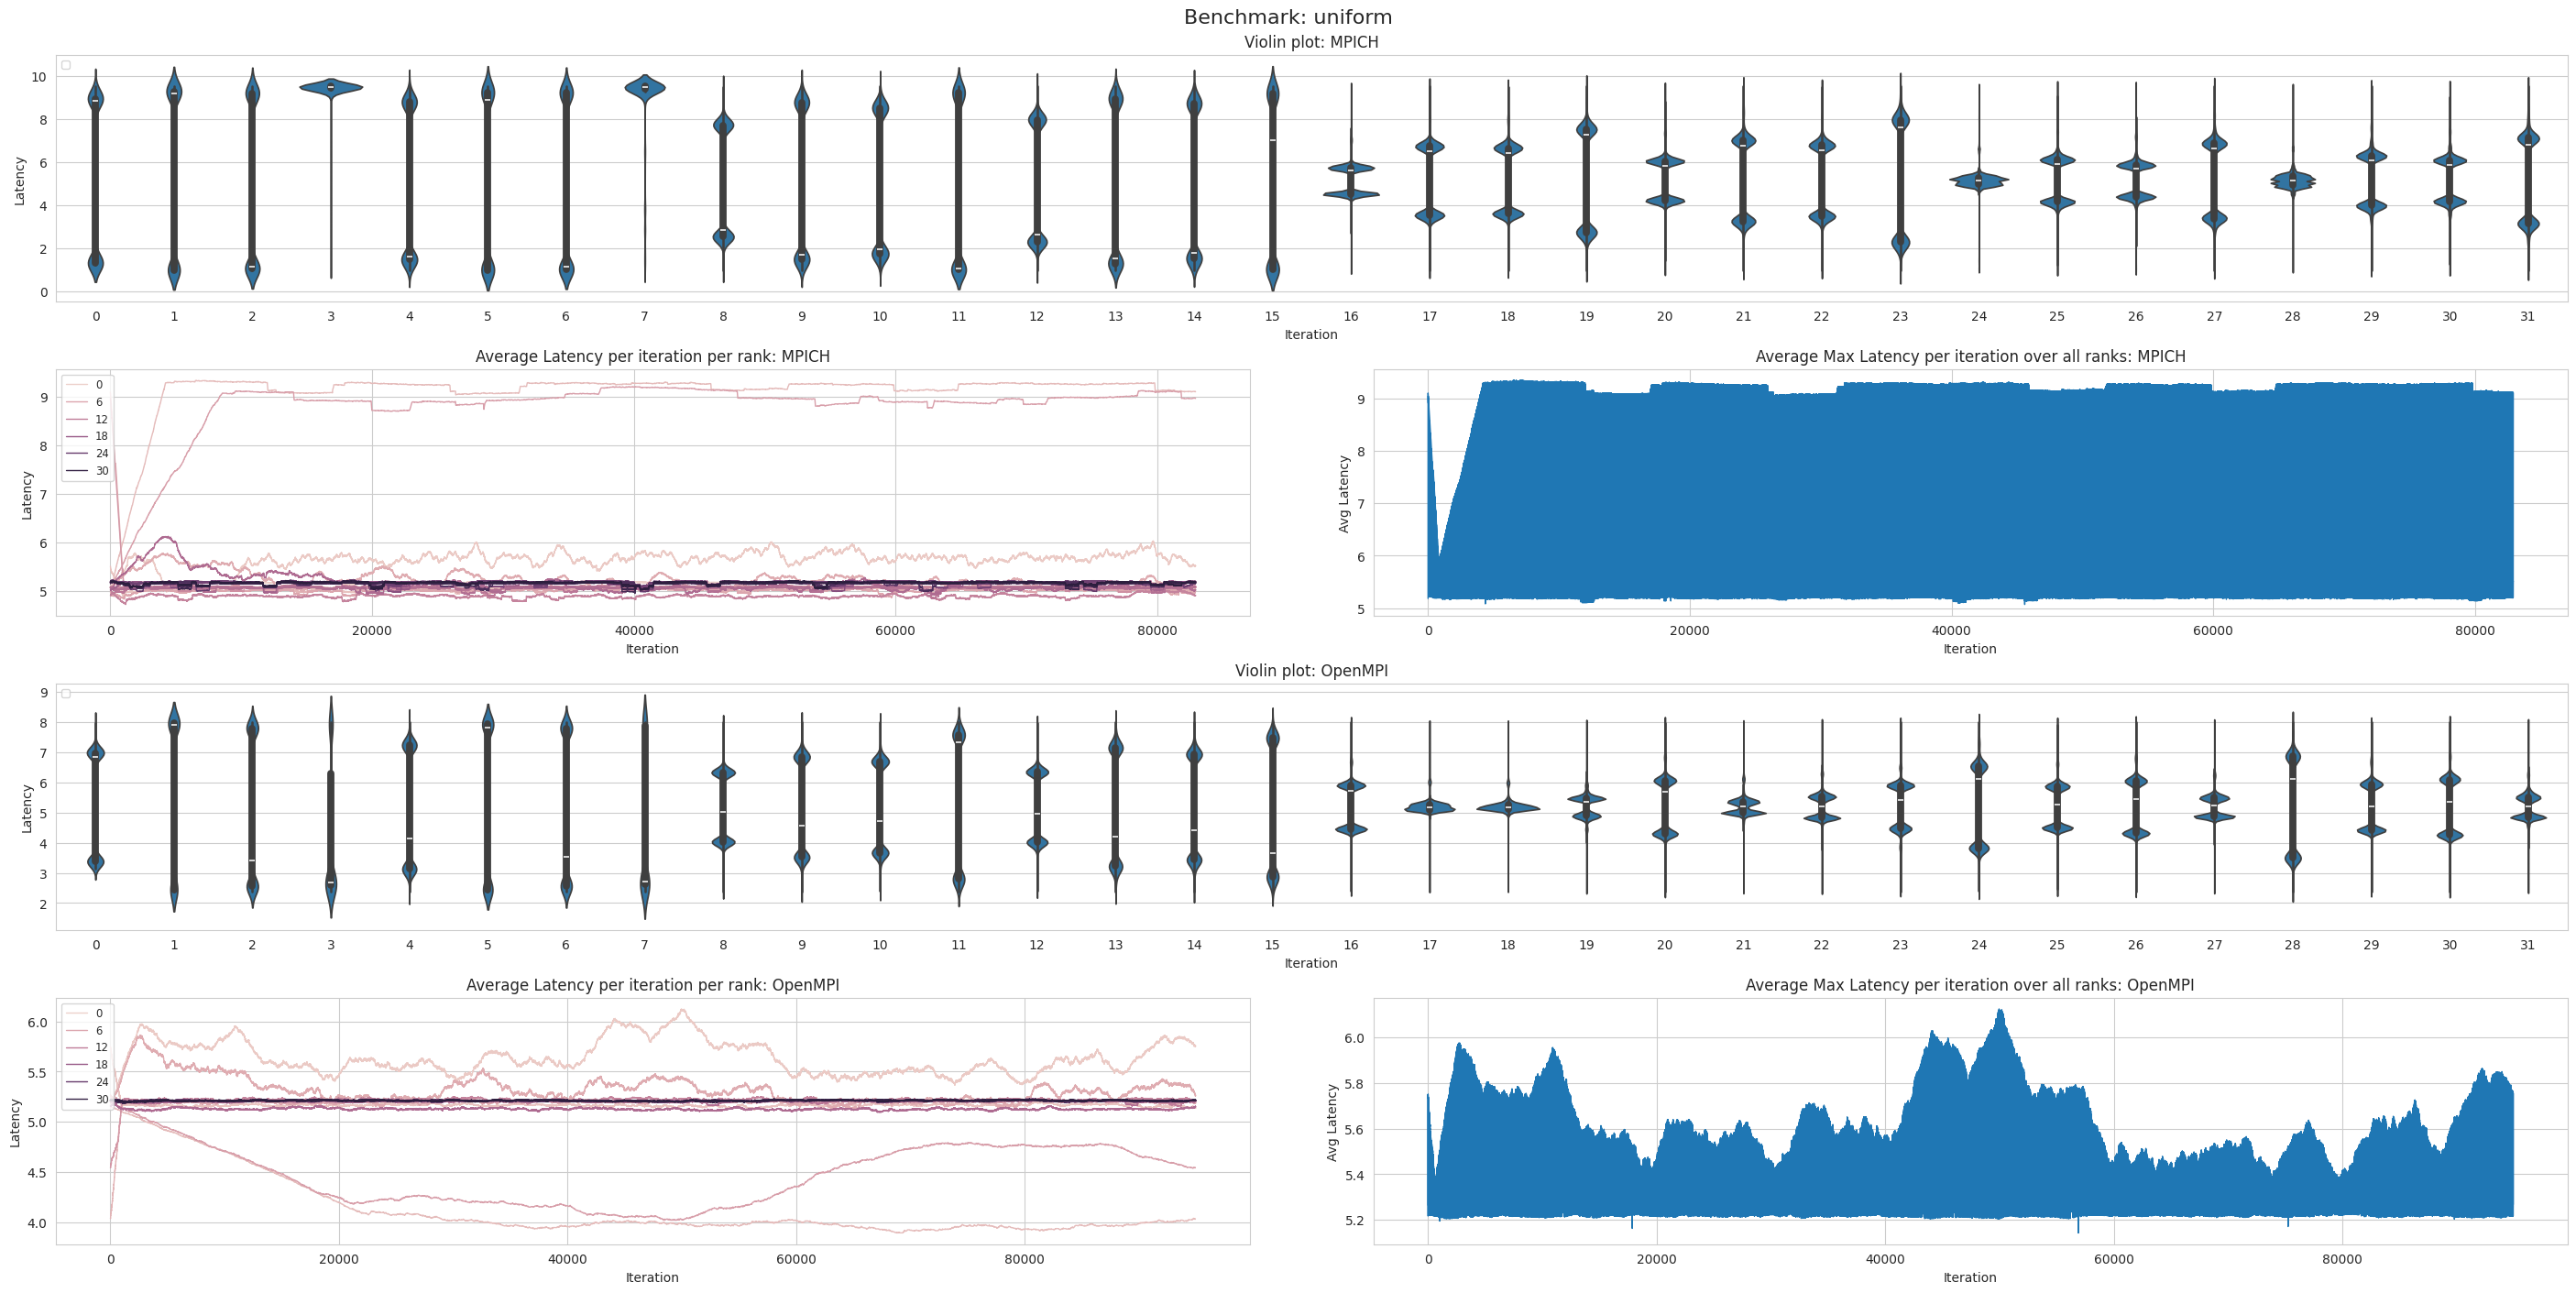

In [12]:
plot("uniform")

# Bucket

``` json
{
    "test_name": "scatterv-bucket",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "bucket",
        "params": {
            "nproc": 32,
            "avg": 10
        }
    }
}
```

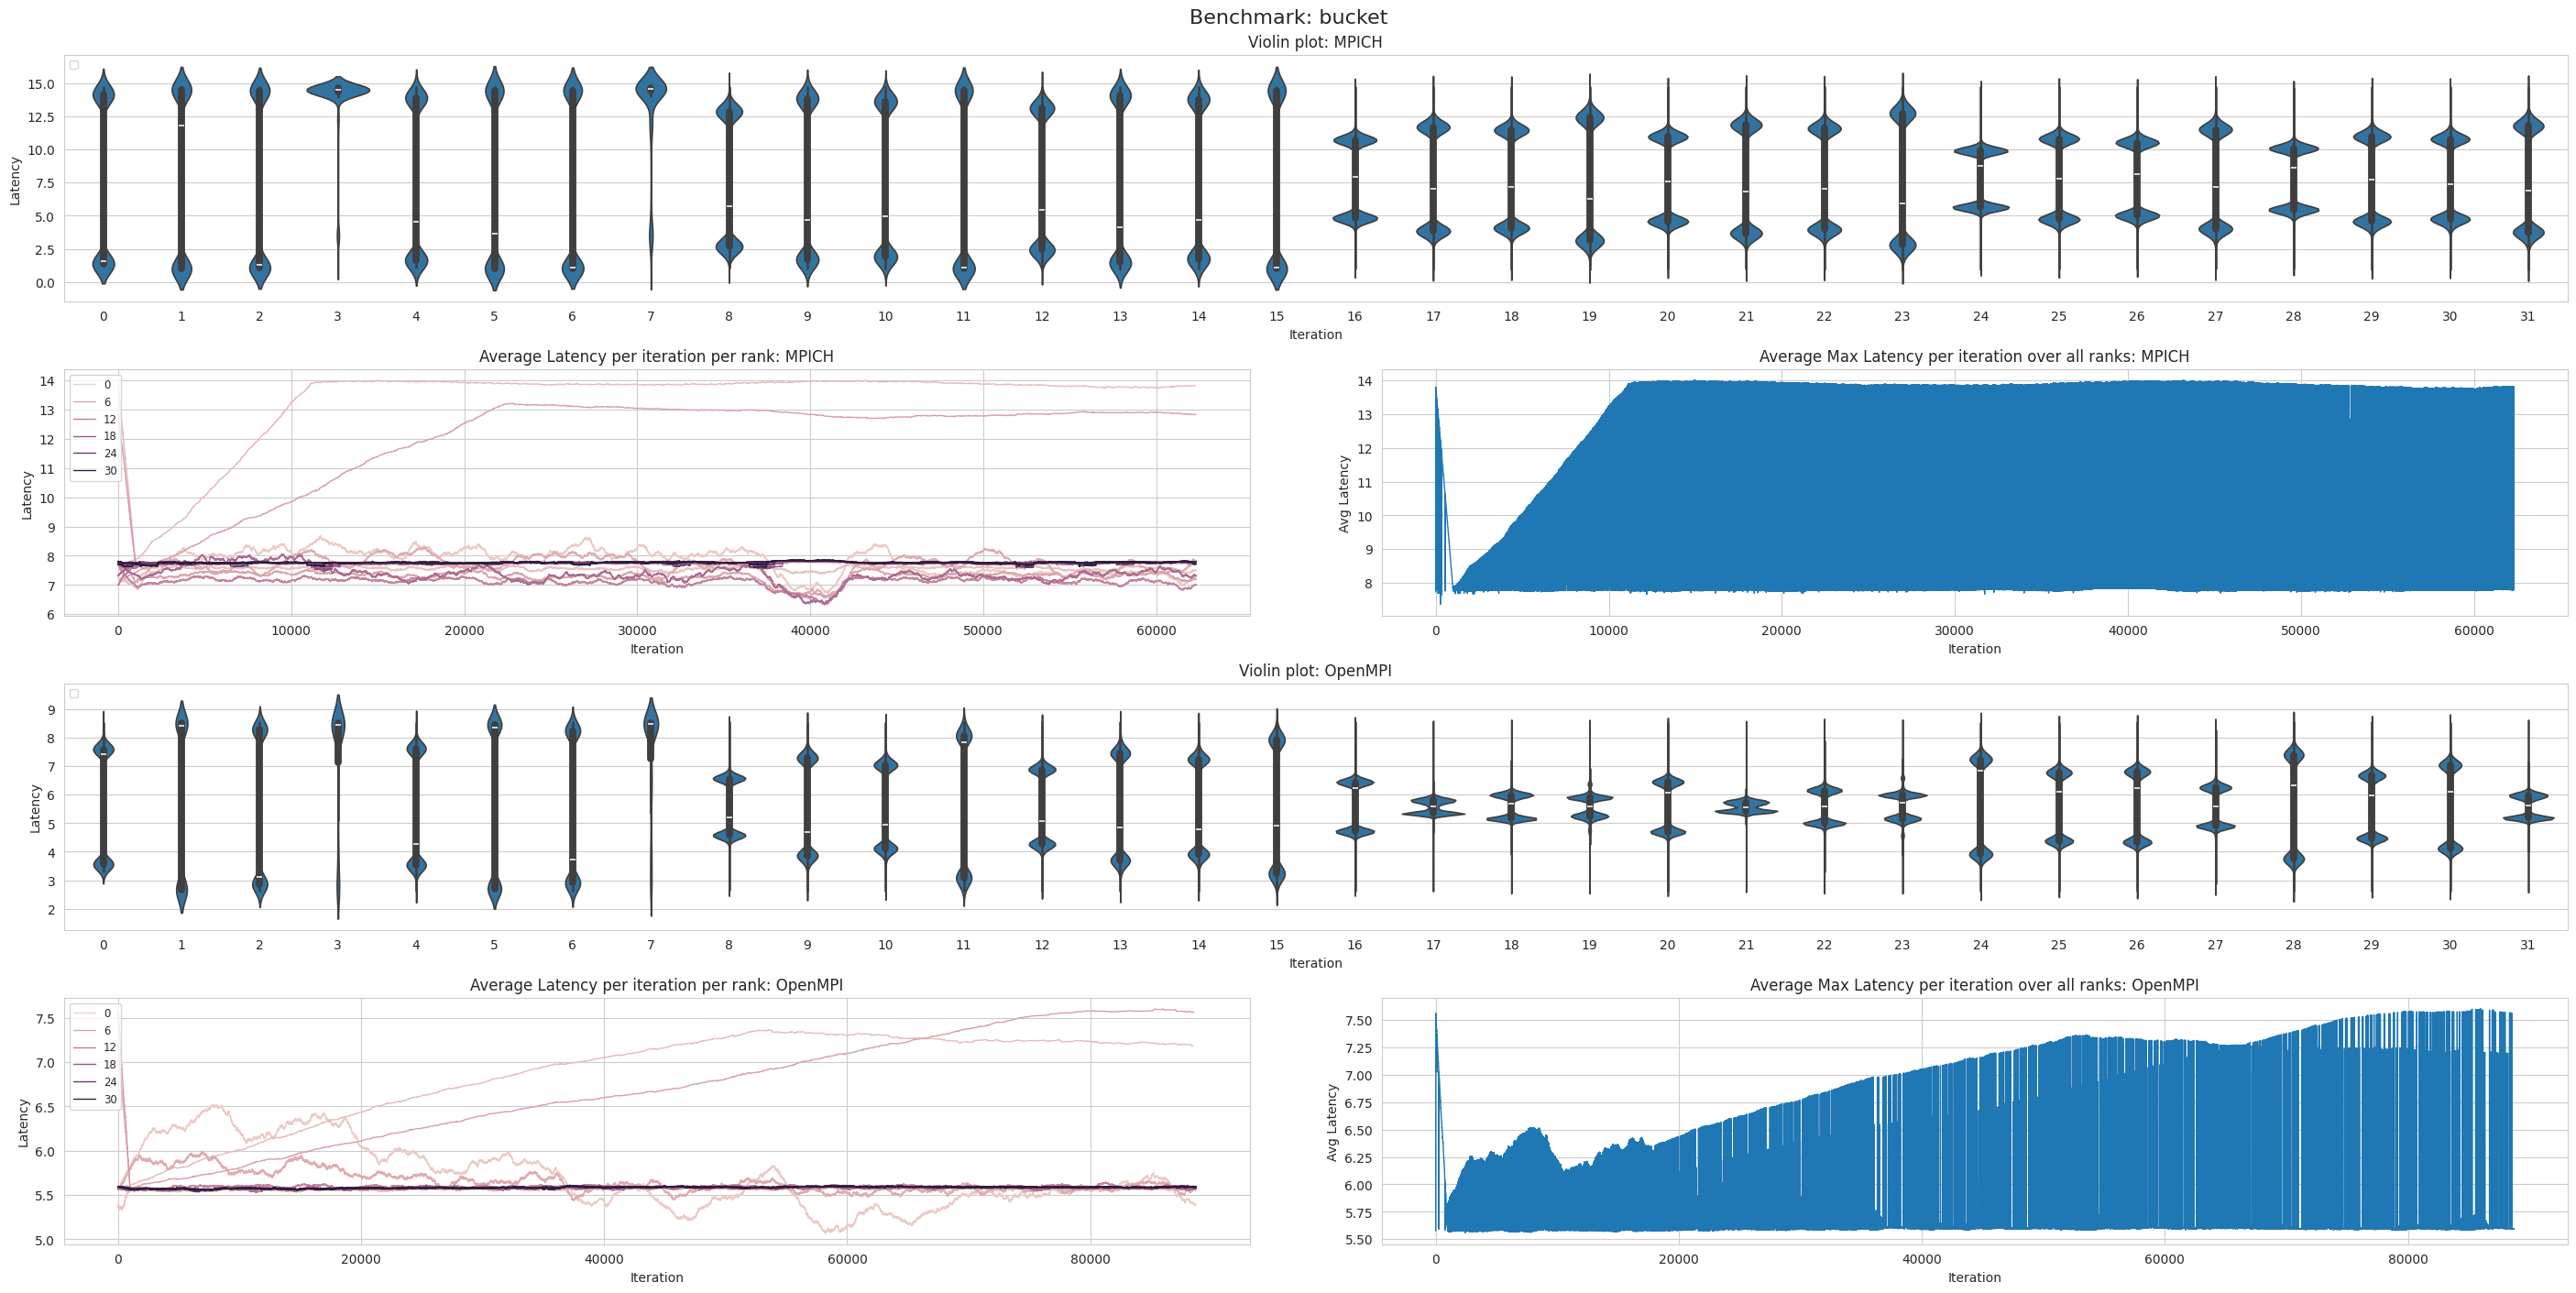

In [13]:
plot("bucket")

 
        
# Spikes

``` json
{
    "test_name": "scatterv-spikes",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "spikes",
        "params": {
            "nproc": 32,
            "avg": 3
        }
    }
}
```

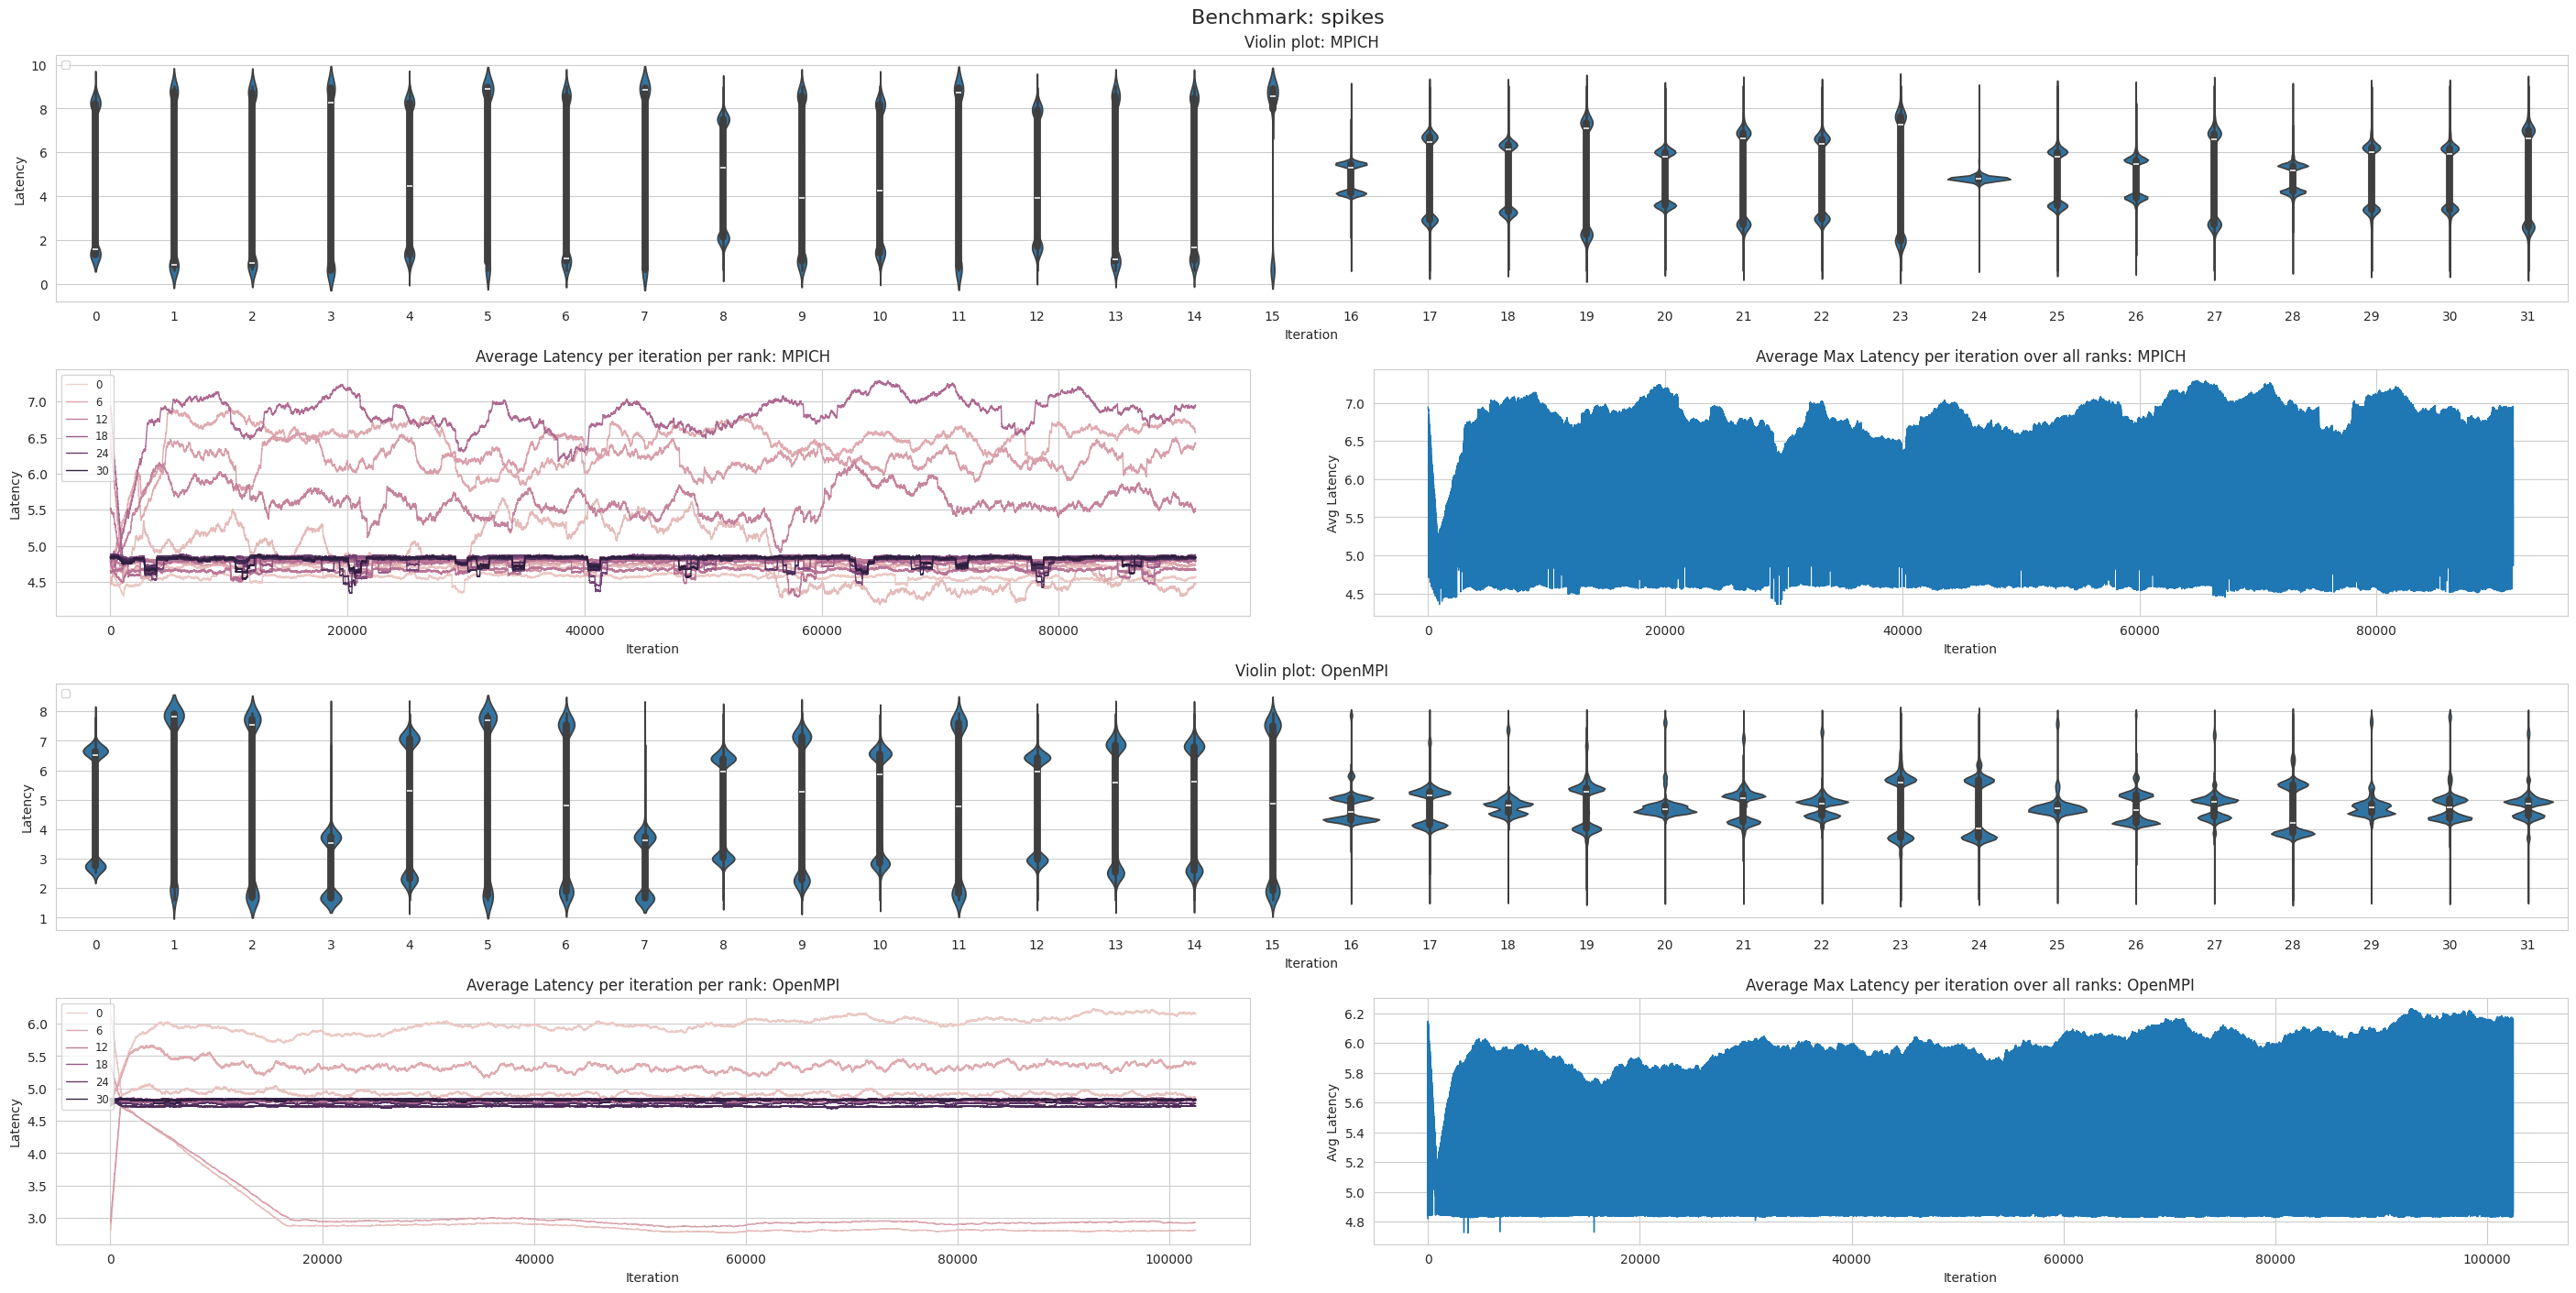

In [14]:
plot("spikes")

# Two Blocks

``` json
{
    "test_name": "scatterv-two-blocks",
    "test_type": "latency",
    "collective": "scatterv",
    "messages_data": {
        "data": "two_blocks",
        "params": {
            "nproc": 32,
            "avg": 3
        }
    }
}
```

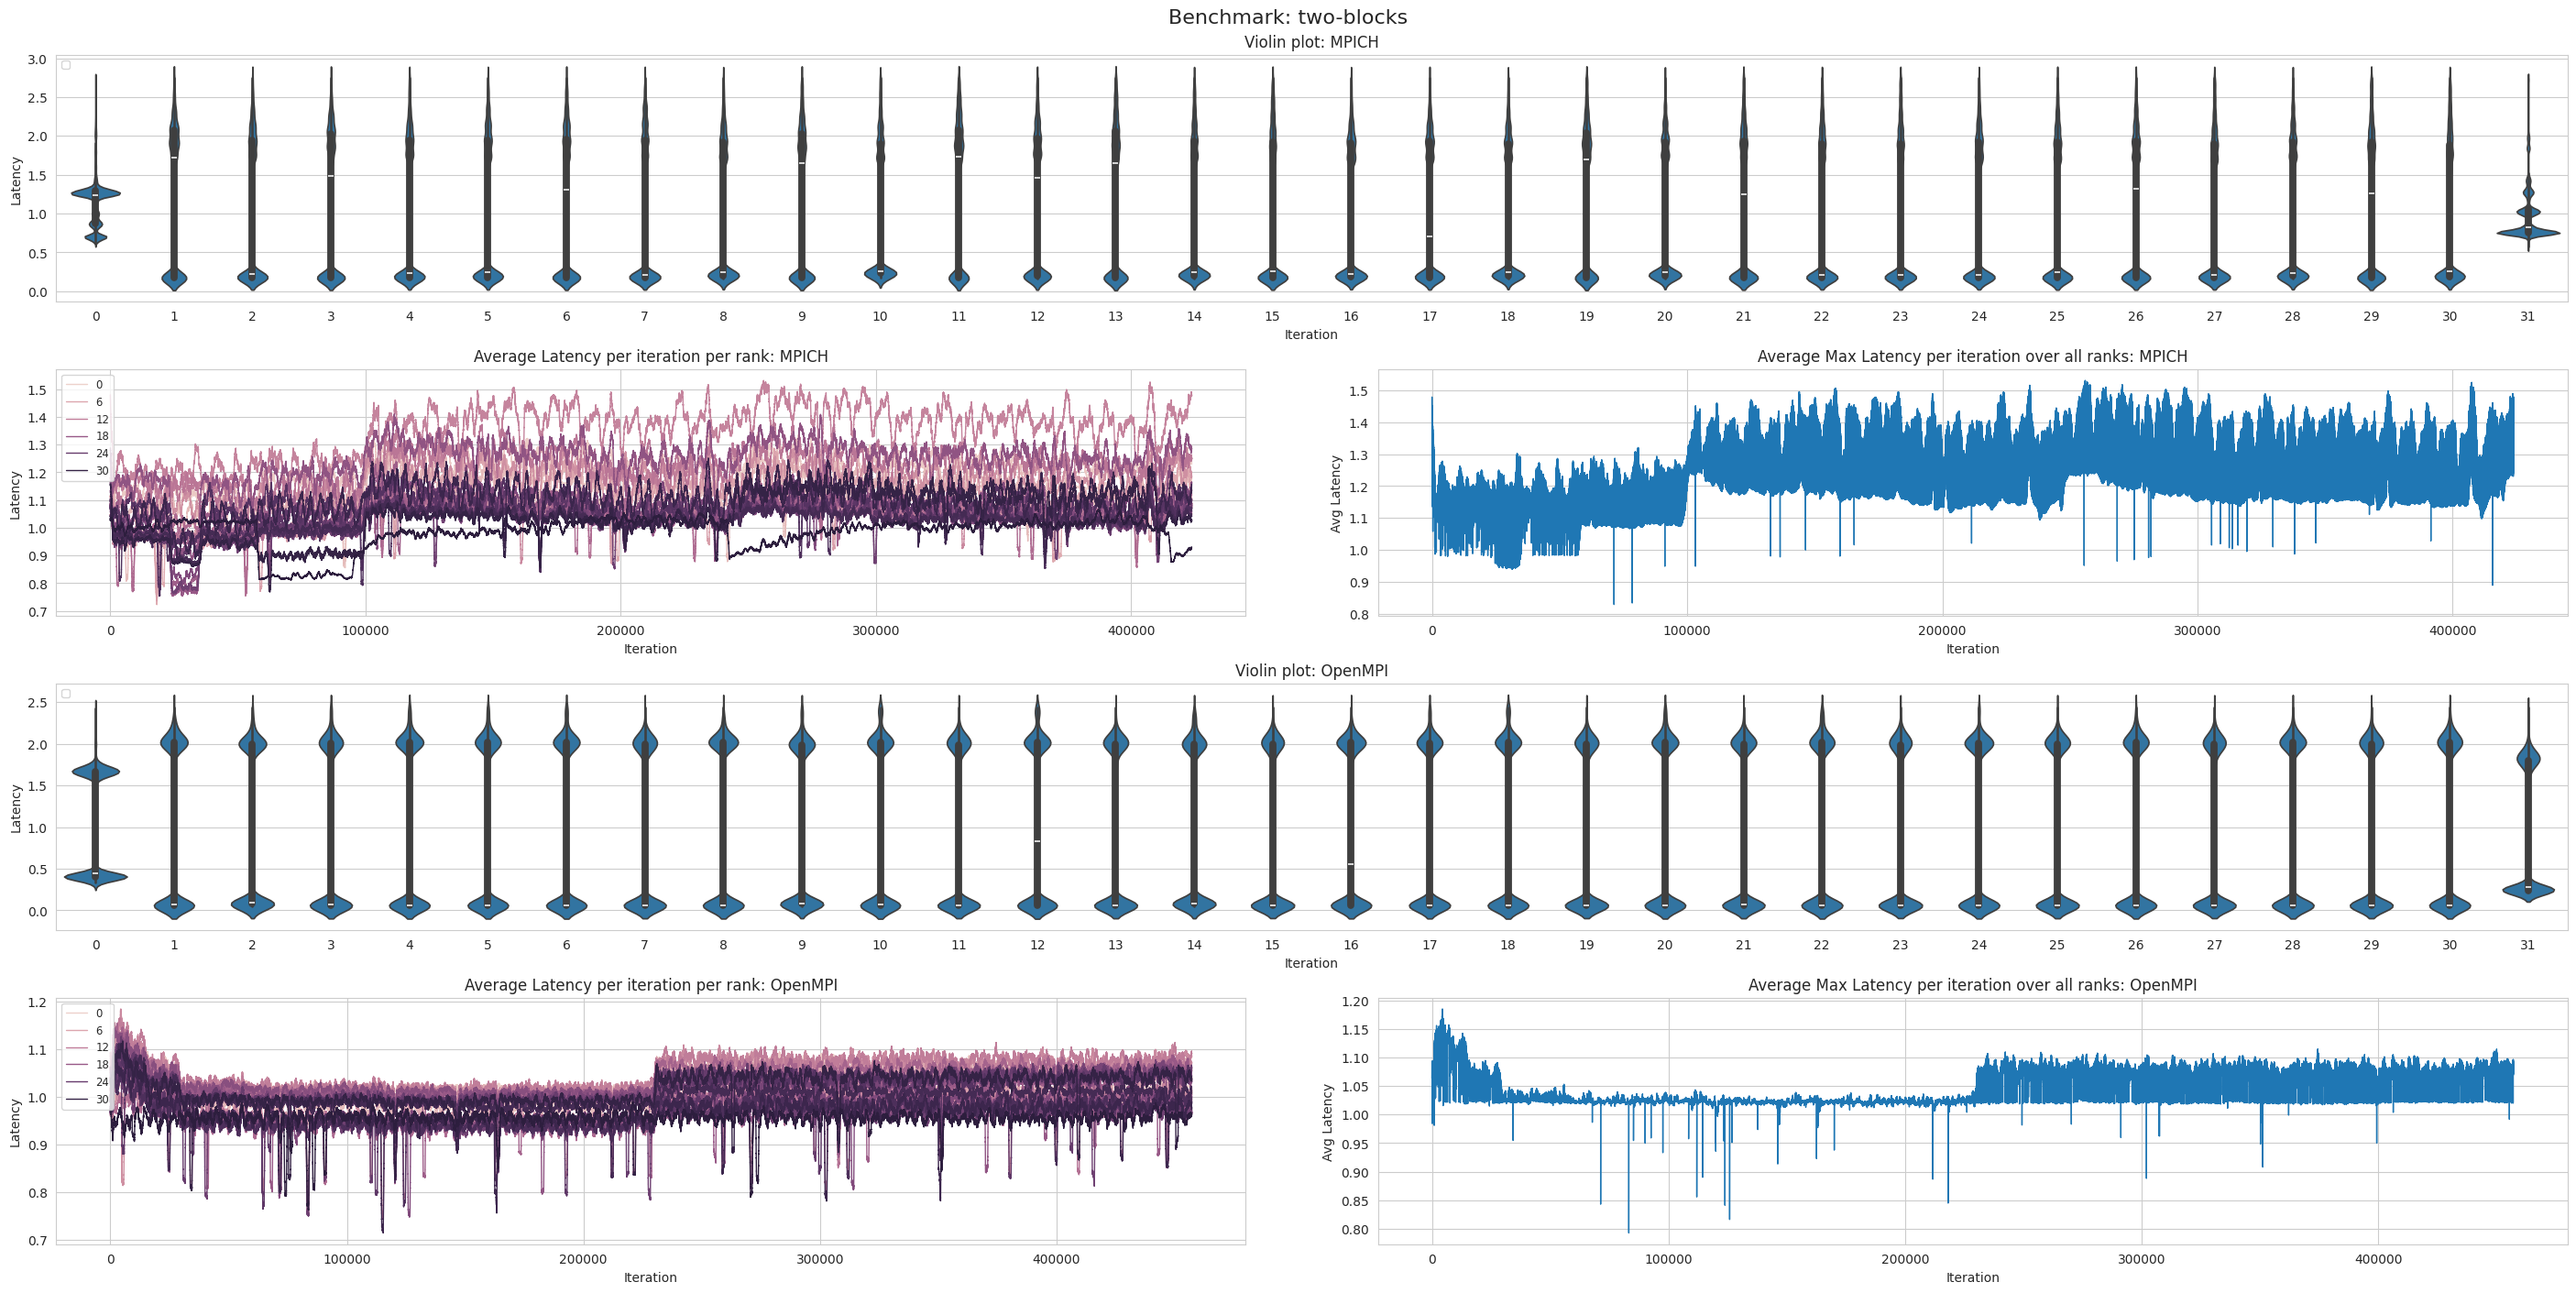

In [15]:
plot("two-blocks")